In [10]:
from petastorm import make_reader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis,skew
from scipy.signal import periodogram
import scipy.signal
from ecgdetectors import Detectors
import matplotlib.ticker as ticker
import pywt
from matplotlib.widgets import TextBox, Button
import sys
#import emd
#import pandas as pd



In [11]:
##Read the dataset
path_formatted_glasgow = "/workspaces/maitrise/data/20220902_data_physio_formatted_merged/merged/dataParquet"
path_petastorm = f"file:///{path_formatted_glasgow}"
with make_reader(path_petastorm) as reader:
    for sample in reader:
        data = sample
        break


/home/vscode/.local/lib/python3.8/site-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
  self._filesystem = pyarrow.localfs
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
  if not dataset.common_metadata:
/home/vscode/.local/lib/python3.8/site-packages/petastorm/etl/dataset_metadata.py:368: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be 

In [12]:
print(data)

ECGSchema_view(noun_id=b'HR15659', signal_names=array([b'I', b'II', b'III', b'aVR', b'aVL', b'aVF', b'V1', b'V2', b'V3',
       b'V4', b'V5', b'V6'], dtype='|S3'), signal=array([[-0.175, -0.15 ,  0.025, ...,  0.075,  0.025, -0.075],
       [-0.175, -0.15 ,  0.025, ...,  0.075,  0.025, -0.075],
       [-0.175, -0.15 ,  0.025, ...,  0.075,  0.025, -0.075],
       ...,
       [-0.3  ,  0.05 ,  0.35 , ..., -1.025, -1.025, -0.775],
       [-0.3  ,  0.05 ,  0.35 , ..., -1.025, -1.025, -0.775],
       [-0.3  ,  0.05 ,  0.35 , ..., -1.025, -1.025, -0.775]],
      dtype=float32), diagnostics=array([ 39732003, 164865005, 164951009, 426783006]), score_classes=array([ 39732003, 426783006]), signal_length=5000, sampling_frequency=500, age=65, sex=b'Male')


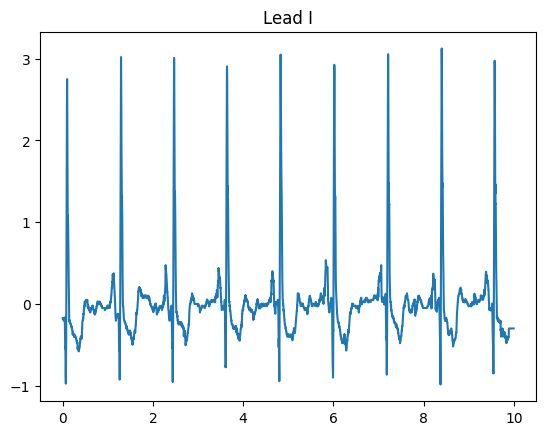

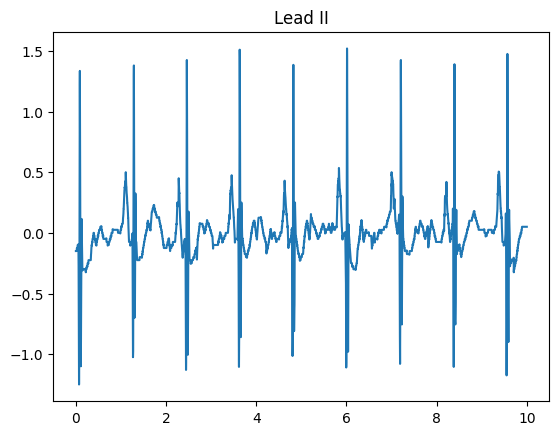

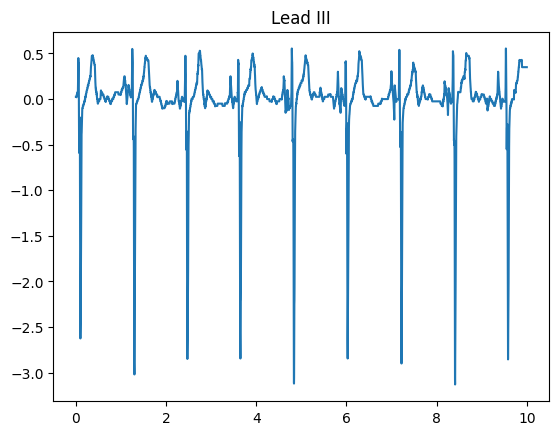

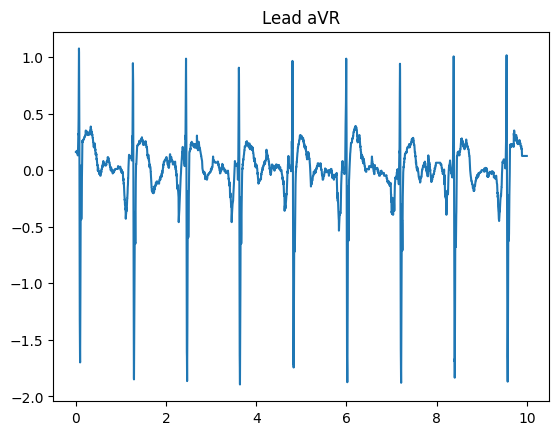

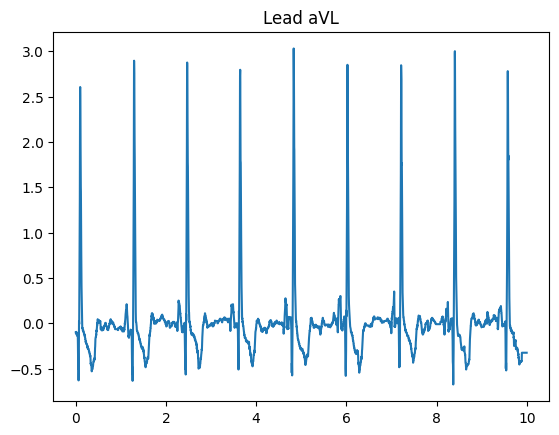

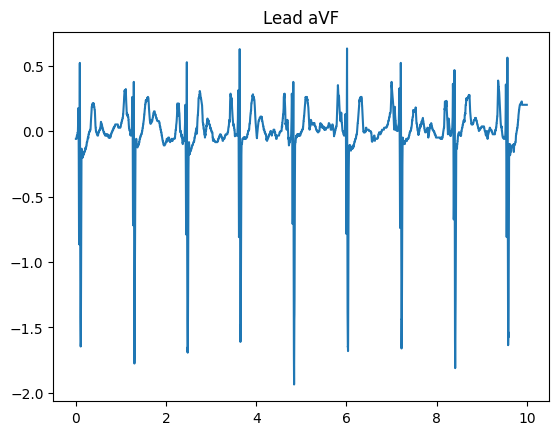

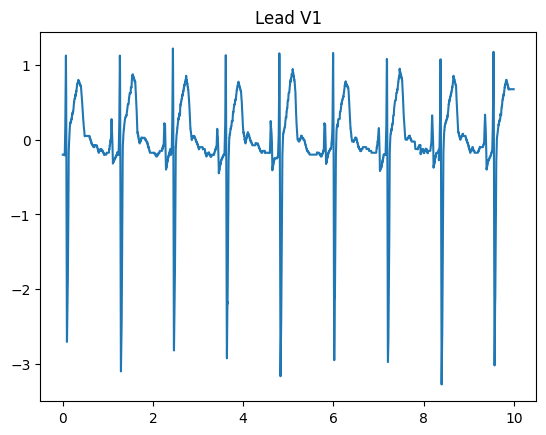

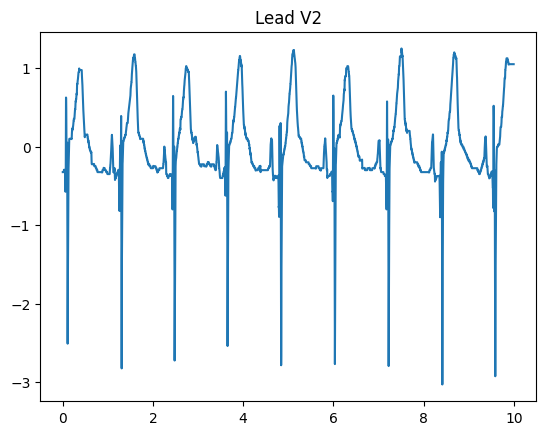

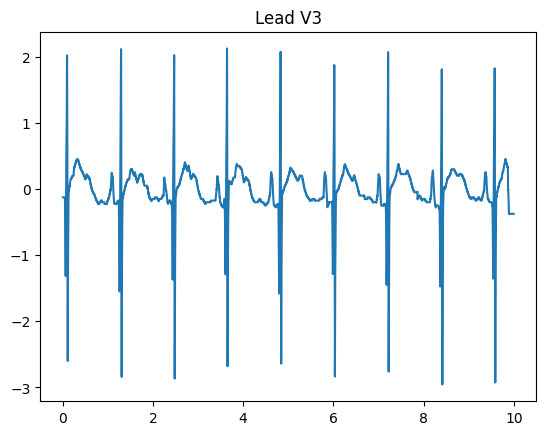

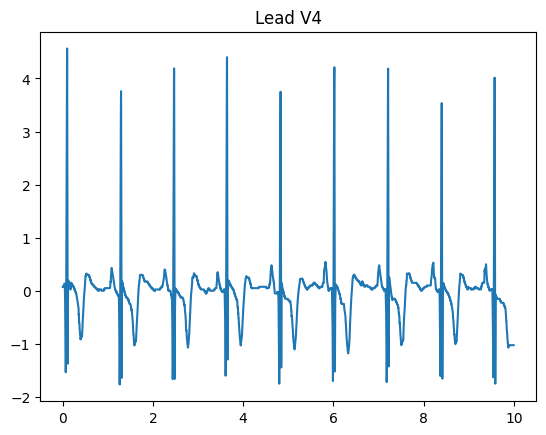

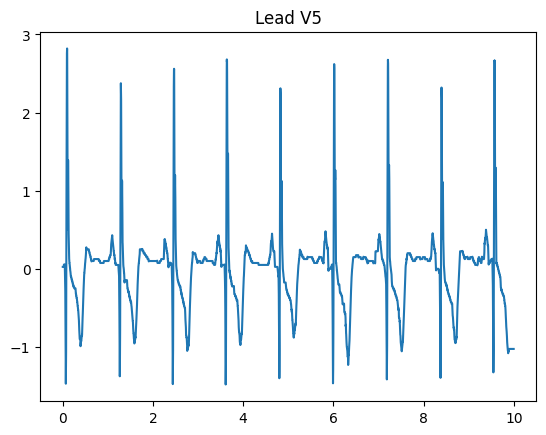

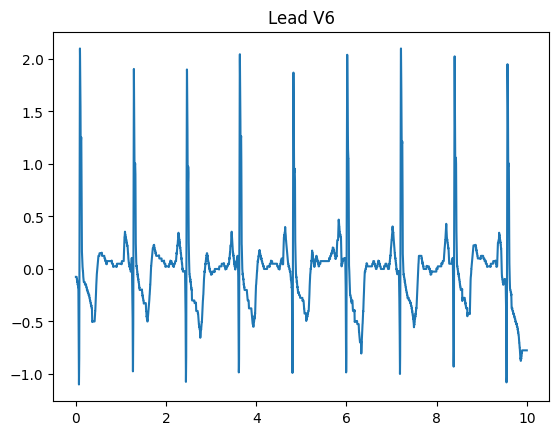

In [13]:
ECG_signal = data.signal
ECG_lead = data.signal_names
dico_ECG = {}
for i,j in zip(ECG_lead,range(12)):
    
     dico_ECG[i] = ECG_signal[:,j]
     x = np.array(range(0,data.signal_length))
     x = x/data.sampling_frequency
     plt.figure()
     plt.plot(x,ECG_signal[:,j])
     plt.title(f"Lead {i.decode('utf8')}")
     plt.show()



In [ ]:
##Kurtosis SQI factor :
def kurtosis_SQI(signal):
    return (1/len(signal))*np.sum((signal-np.mean(signal))**4)/(np.std(signal)**4)

##Skewness SQI factor:
def Skewness_SQI(signal):
    return (1/len(signal))*np.sum((signal-np.mean(signal))**3)/(np.std(signal)**3)

for i in ECG_lead:
    print(f"for lead {i.decode('utf8')} : ")
    for j in range(5):
        print("Kurtosis = ",kurtosis_SQI(dico_ECG[i][j*1000:(1000)*(j+1)]), " and Skewness = ", Skewness_SQI(dico_ECG[i][j*1000:(1000)*(j+1)]))
    print("For the entire signal : Kurtosis = ",kurtosis_SQI(dico_ECG[i])," and Skewness = ",Skewness_SQI(dico_ECG[i]))
    print("For the entire signal : Comb_SQI = ",(np.abs(Skewness_SQI(dico_ECG[i]))/5)*kurtosis_SQI(dico_ECG[i]))
    fig,ax = plt.subplots(nrows = 1,ncols = 2, figsize = (20,10))
    ax[0].plot(dico_ECG[i])
    ax[0].grid()
    ax[0].set_title(f"lead {i.decode('utf8')}")
    ax[1].hist(dico_ECG[i])
    ax[1].set_title(f"Histogram for lead {i.decode('utf8')}")
    plt.show()

In [ ]:
#SDR factor :

def SDR(signals,ECG_lead,fs = data.sampling_frequency):
    for i in ECG_lead:
        for j in range(5):
            f,PSD = periodogram(signals[i][j*1000:(1000)*(j+1)],fs)
            ECG_signal_PSD = np.sum(PSD[np.logical_and(f>5,f<14)])
            ECG_tot = np.sum(PSD[np.logical_and(f>5,f<50)])
            SDR_val = ECG_signal_PSD/ECG_tot
            print(f"for lead {i.decode('utf8')} between [{j*1000},{(j+1)*(1000)}]:",SDR_val)
        f,PSD = periodogram(signals[i],fs)
        QRS_signal_PSD = np.sum(PSD[np.logical_and(f>5,f<14)])
        ECG_tot = np.sum(PSD[np.logical_and(f>5,f<50)])
        SDR_val = QRS_signal_PSD/ECG_tot
        XECG = scipy.fft.fft(dico_ECG[i])
        XECG = (2/data.signal_length)*XECG[:data.signal_length//2]
        xf = scipy.fft.fftfreq(data.signal_length,1/data.sampling_frequency)[:data.signal_length//2]
        IOR = np.sum(np.abs(XECG[np.logical_and(xf>5,xf<40)]))/(np.sum(np.abs(XECG[np.logical_and(xf>0,xf<120)]))-np.sum(np.abs(XECG[np.logical_and(xf>5,xf<40)])))
        print(f"SDR for the entire signal of lead {i.decode('utf8')} :",SDR_val)
        print(f"IOR for the entire signal of lead {i.decode('utf8')} :",IOR)
        fig,ax = plt.subplots(nrows = 1,ncols = 3, figsize = (20,10))
        ax[0].plot(dico_ECG[i])
        ax[0].set_title(f"lead {i.decode('utf8')}")
        ax[1].plot(xf,np.abs(XECG))
        ax[1].set_title(f"FT of lead {i.decode('utf8')}")
        ax[2].semilogy(f, PSD)
        ax[2].set_ylim([1e-7, 1e2])
        ax[2].set_title(f"PSD of lead {i.decode('utf8')}")
        plt.show()
        #plt.semilogy(f, PSD)
        #plt.ylim([1e-7, 1e2])
        #plt.xlabel('frequency [Hz]')
        #plt.ylabel('PSD [V**2/Hz]')
        #plt.show()
        
SDR(dico_ECG,ECG_lead)       

In [ ]:
#Beats detector ECG
def QRS_detector(signal,lead,fs = data.sampling_frequency):
    detect = Detectors(fs)
    for i in lead:
        r_peaks = detect.pan_tompkins_detector(signal[i])
        print(r_peaks)
        plt.plot(signal[i],marker = "o",markerfacecolor = "red",color = "b",markevery = r_peaks,label = "R-peaks detected")
        plt.legend()
        plt.title(f"R-peaks for lead {i.decode('utf-8')}")
        plt.show()

QRS_detector(dico_ECG,ECG_lead)

In [ ]:
##Wavelet decomposition

for i in ECG_lead:
    fig, ax = plt.subplots(figsize=(6,1))
    ax.set_title(f"Original signal for lead {i.decode('utf8')}")
    ax.plot(dico_ECG[i])
    plt.show() 
    data = dico_ECG[i]
    waveletname = 'db4'
 
    fig, axarr = plt.subplots(nrows=10, ncols=2, figsize=(10,10))
    for ii in range(10):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        axarr[ii, 0].plot(data, 'r')
        axarr[ii, 1].plot(coeff_d, 'g')
        axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
        axarr[ii, 0].set_yticklabels([])
        if ii == 0:
            axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
            axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        axarr[ii, 1].set_yticklabels([])
    plt.tight_layout()
    plt.show()  


In [6]:
### Try with another python method:
waveletname = 'db4'
level_w = 9
i = ECG_lead[1]

def Wavelet_coef(sig,name,lev):
    All_coeff = pywt.wavedec(sig,name,level = lev)

    CA_w = All_coeff[0]
    CD_w = All_coeff[1:len(All_coeff)]
    #fig, ax = plt.subplots(figsize=(6,1))
    #ax.set_title(f"approximation signal at level {lev} for lead {i.decode('utf8')}")
    #ax.plot(CA_w)
    #plt.show()

    #fig, axarr = plt.subplots(nrows=lev, ncols=1, figsize=(lev,lev))
    #for j in range(len(CD_w)):
        #axarr[j].plot(np.asarray(CD_w)[-(j+1)])
        #axarr[j].set_ylabel("Level {}".format(j + 1), fontsize=14, rotation=90)
        #axarr[j].set_yticklabels([])
        #if j ==0:
            #axarr[j].set_title("detail coefficients", fontsize=14)
    
    #plt.tight_layout()
    #plt.show()
    return CA_w,CD_w  


SQI_QRS for lead I : 0.4146090131253004


/tmp/ipykernel_434/3415381877.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p = np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])/Etot)


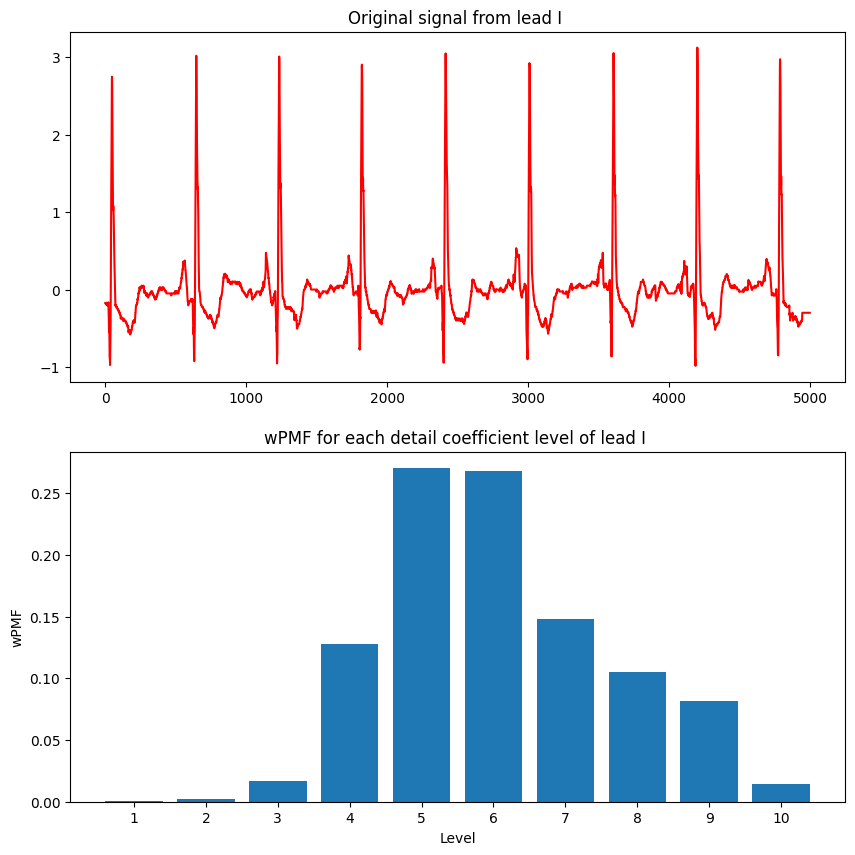

SQI_QRS for lead II : 0.6434561908245087


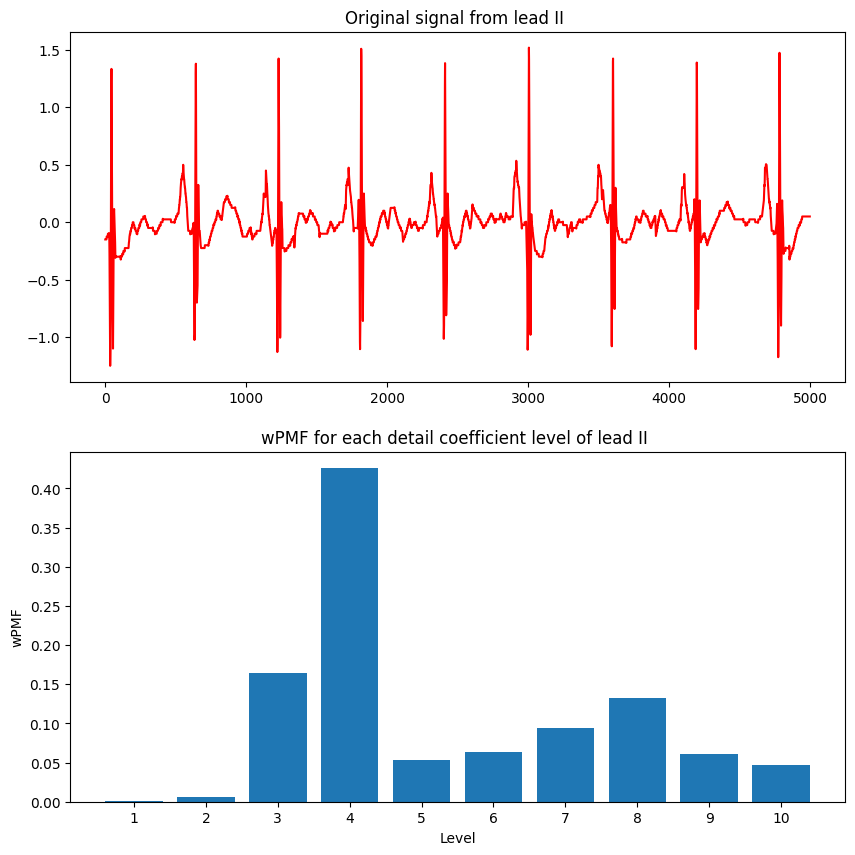

SQI_QRS for lead III : 0.3900666106492281


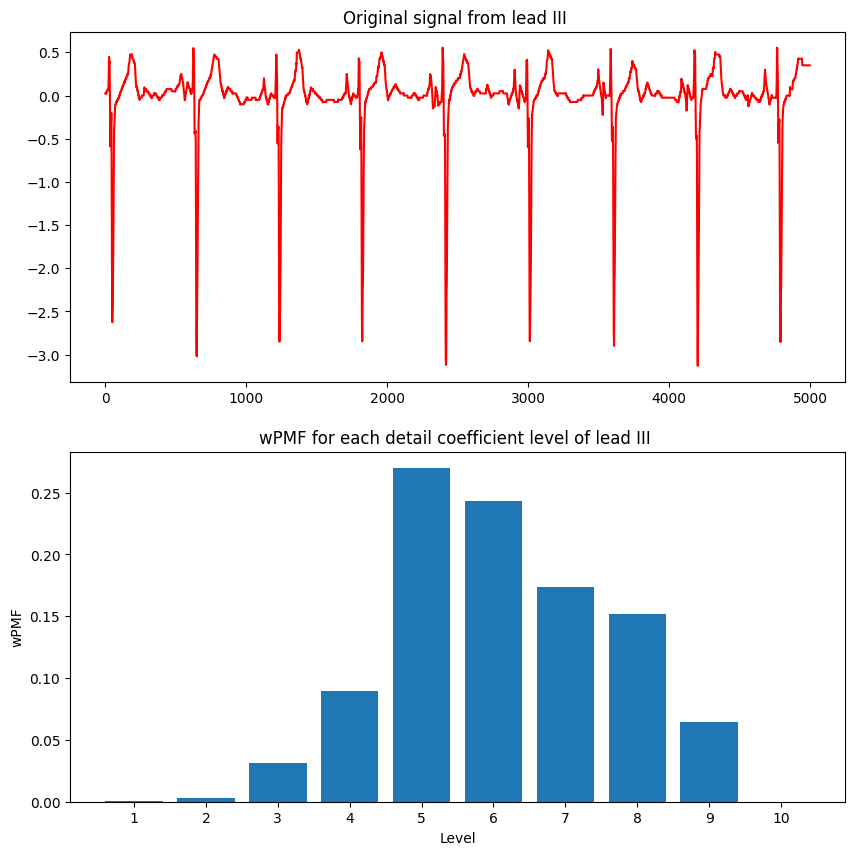

SQI_QRS for lead aVR : 0.4992200769484043


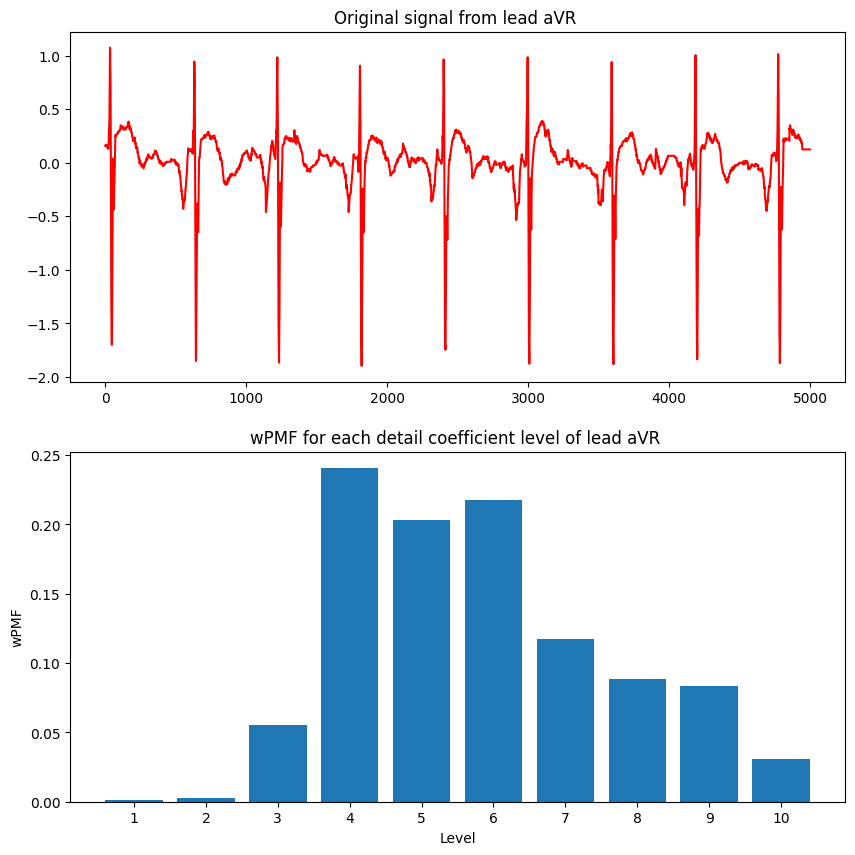

SQI_QRS for lead aVL : 0.38605661410838366


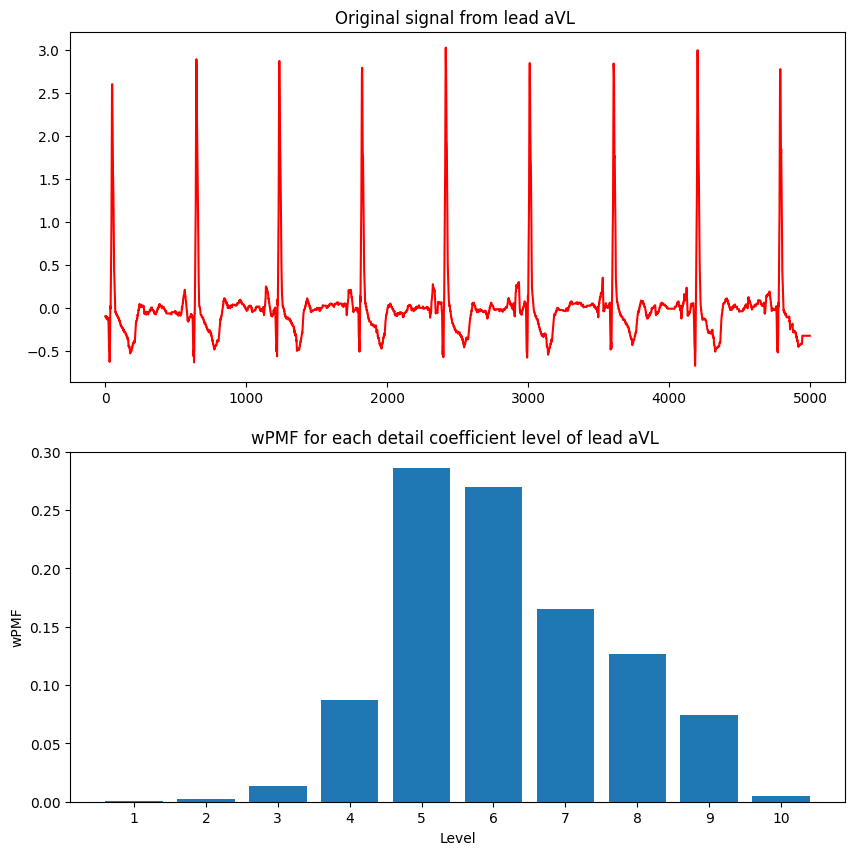

SQI_QRS for lead aVF : 0.4736630544066429


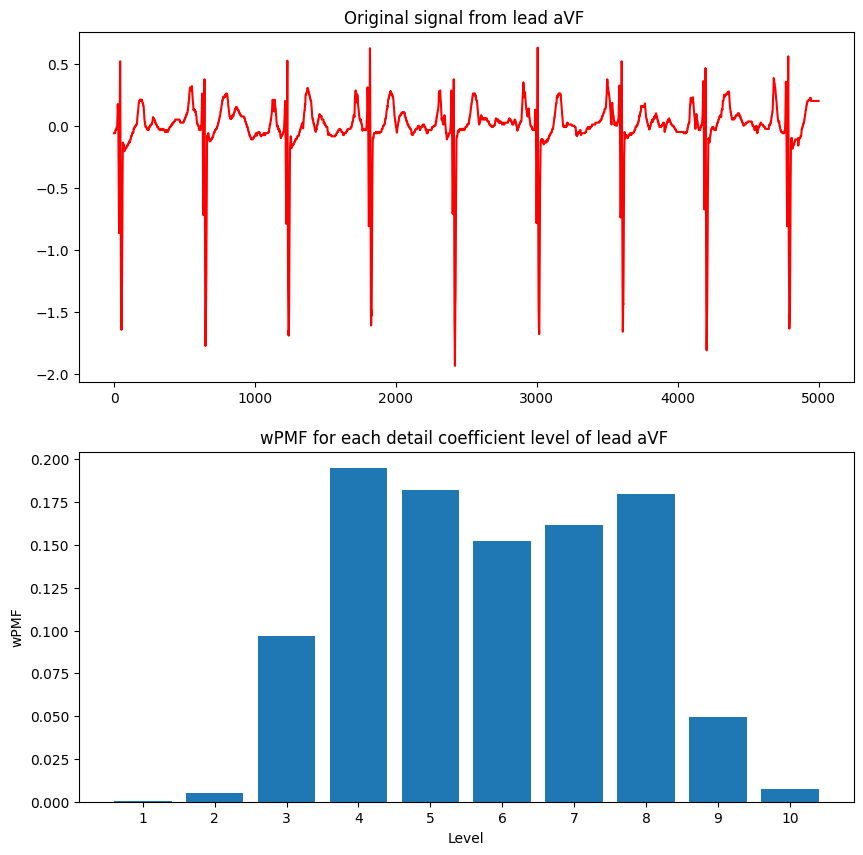

SQI_QRS for lead V1 : 0.3567228792235255


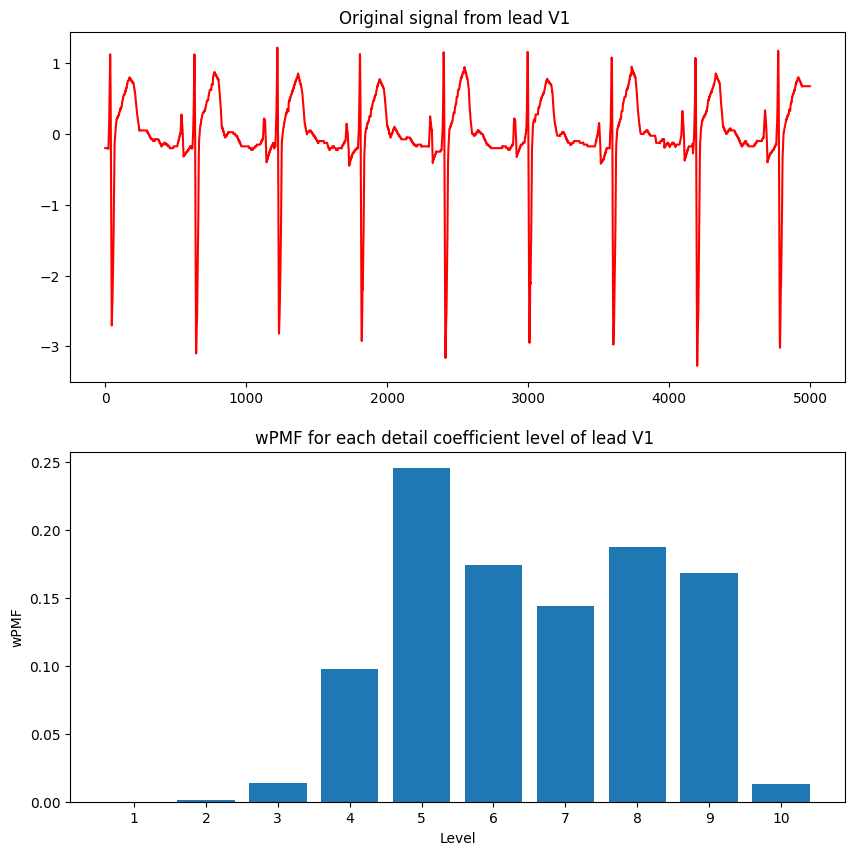

SQI_QRS for lead V2 : 0.16292181611061096


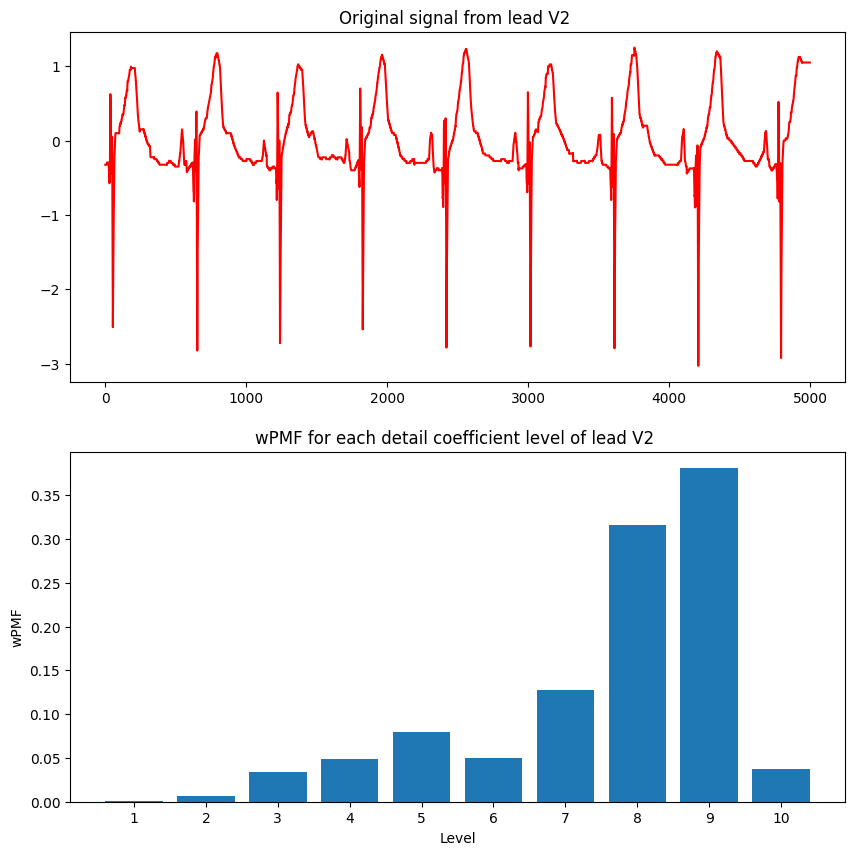

SQI_QRS for lead V3 : 0.6715013533830643


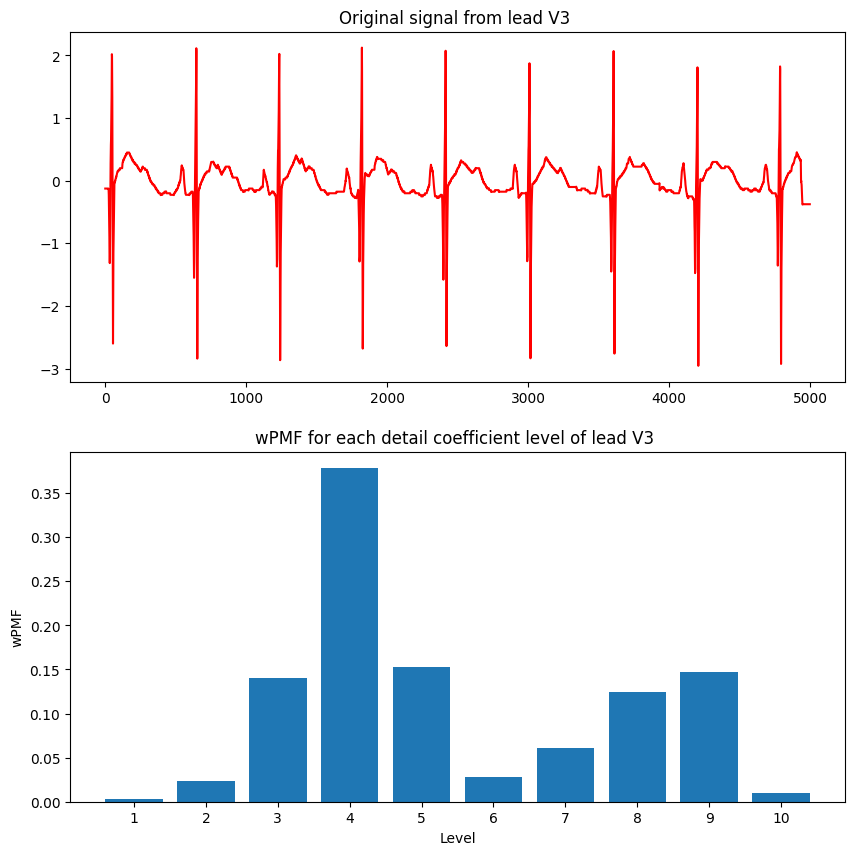

SQI_QRS for lead V4 : 0.5898054912686348


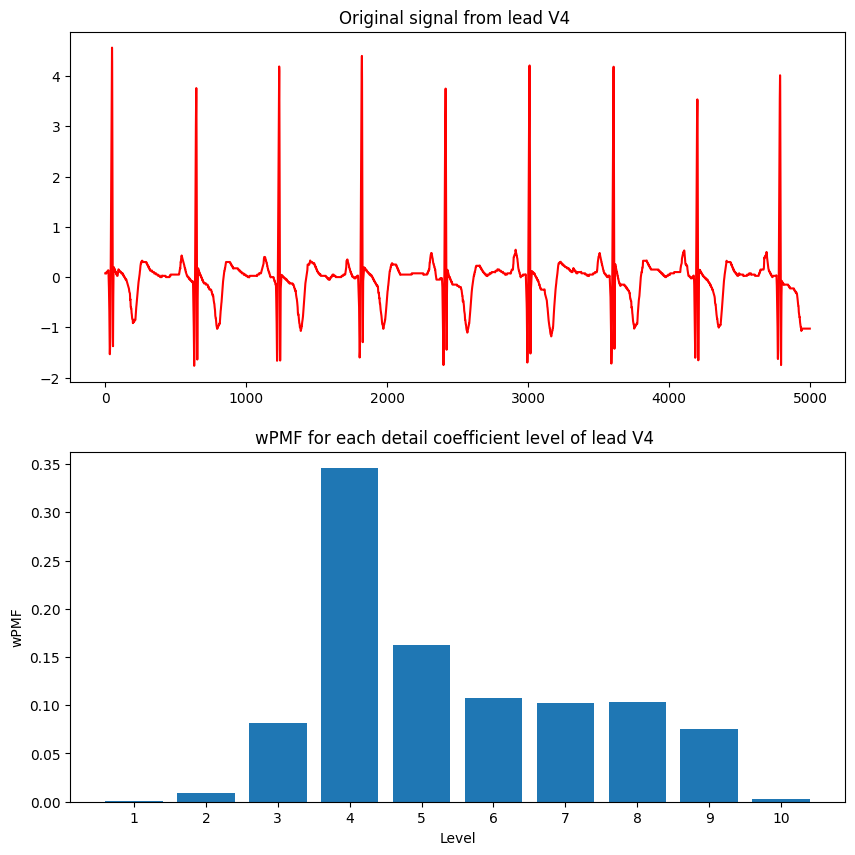

SQI_QRS for lead V5 : 0.36332280188798904


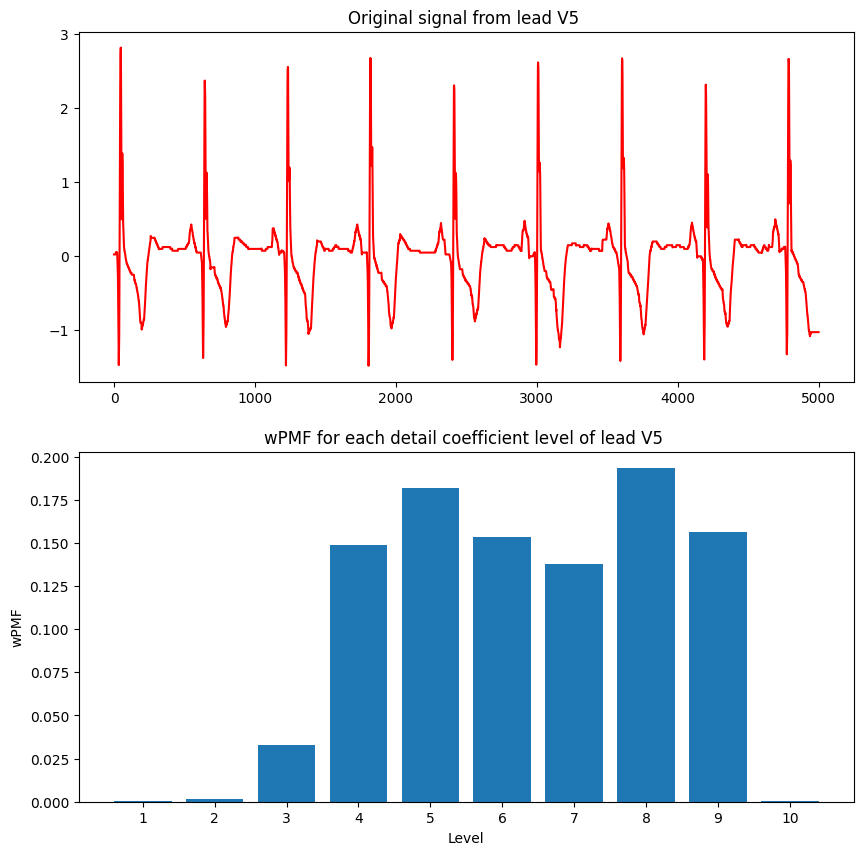

SQI_QRS for lead V6 : 0.3654559291899204


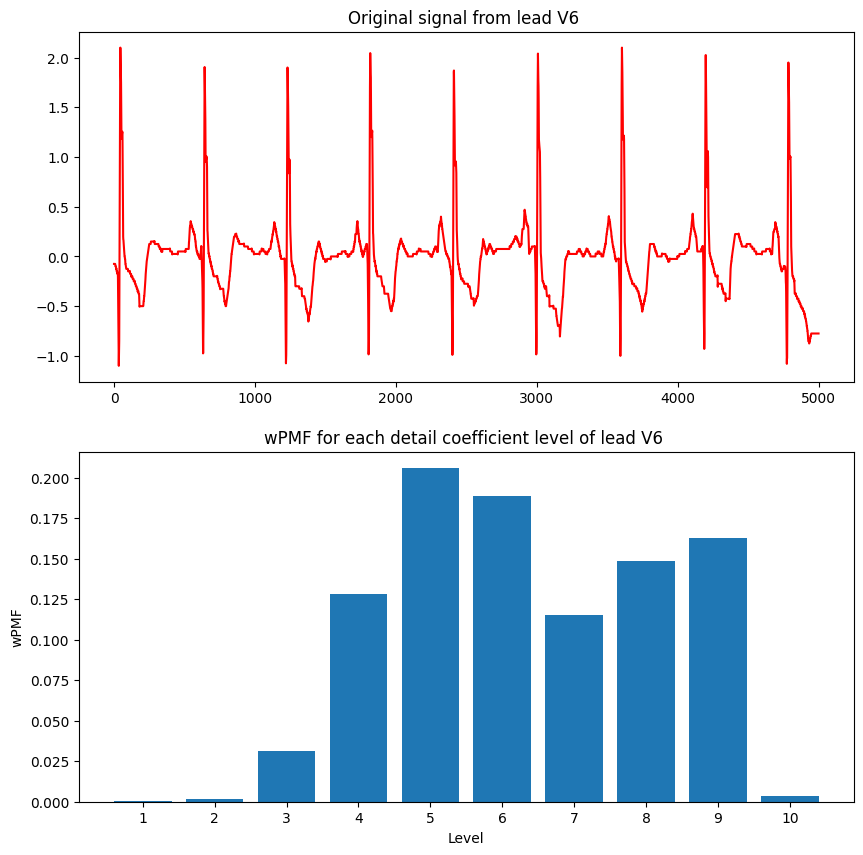

In [14]:
##Calcuation of the wPMF (wavelet probability  mass function):

def Energy_L2(coeff):
    return np.sum(np.abs(coeff)**2)

for i in ECG_lead:
    CA_w,CD_w = Wavelet_coef(dico_ECG[i],waveletname,level_w)
    Etot = Energy_L2(dico_ECG[i])
    p = np.array([])
    for CD in range(level_w):
        p = np.append(p,Energy_L2(np.asarray(CD_w)[-(CD+1)])/Etot)
    p = np.append(p,Energy_L2(np.asarray(CA_w)[0])/Etot)
    SQI_ECG = np.sum(p[2:5])
    print(f"SQI_QRS for lead {i.decode('utf8')} :",SQI_ECG)
    fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
    ax[0].set_title(f"Original signal from lead {i.decode('utf8')} ")
    ax[0].plot(dico_ECG[i],'r')
    ax[1].set_title(f"wPMF for each detail coefficient level of lead {i.decode('utf8')} ")
    ax[1].bar(range(1,level_w+2),p)
    plt.xticks(range(1,level_w+2),range(1,level_w+2))
    ax[1].set_xlabel("Level")
    ax[1].set_ylabel("wPMF")
    plt.show()

    
    


In [8]:
##MSSR method
def conv_m(a, b, mode='full'):
    """Convolve a vector with collection of vectors.
    Convolve a 1D array `a` with each column of the 2D array `b`.   
    
    Convolution is carried out with `scipy.signal.fftconvolve`
    
    Parameters
    ----------
    a : 1D array
        1D array input
        
    b : 1D or 2D array_like
        1D or 2D array input
        
    mode : str {'full', 'same'}, optional
        A string indicating the size of the output:
        ``full``
           The output is the full discrete linear convolution
           of the inputs. (Default)
        ``same``
           The output is the same size as `a`, centered
           with respect to the 'full' output.
    Returns
    -------
    c : 2D array
        A 2D array where each columns corresponds to the 
        convolution of `a` and a column of `b`
    
    See Also
    --------
    `scipy.signal.fftconvolve()`
        
    """
    # input vector 'a' to 1 dimension
    a = a.ravel()
    # number of samples vector 'a'
    siz_a = len(a)
    
    # input 'b' as 2D matrix [samples, columns]
    try:
        b.shape[1]
    except IndexError:
        b = b[:, np.newaxis]
    
    # number of samples and number of channels in input 'b'
    siz_b, col_b = b.shape
    
    # allocate space for result
    if mode == 'same':
        c = np.zeros((siz_a, col_b) , dtype = complex)
    elif mode == 'full':
        N = siz_a + siz_b - 1
        c = np.zeros((N , col_b), dtype = complex)
    
    # 1D convolutions per columns in 'b'    
    for ix in range(0 , col_b):
         c[:,ix] = scipy.signal.fftconvolve(a, b[:,ix] , mode)
         
    return c


def epoching(data, samples_epoch, samples_overlap = 0):
    """Divide an array in a colletion of smaller arrays
    
    Divides the `data` provided as [n_samples, n_channels] using the 
    `size_epoch` indicated (in samples) and the `overlap_epoch` between 
    consecutive epochs.
   
    Parameters
    ----------
    data : 2D array 
        with shape (n_samples, n_channels)
    samples_epochs : 
        number of samples in smaller epochs
        
    samples_overlap : 
        number of samples for ovelap between epochs (Default 0)
    Returns
    -------
    epochs : 3D array 
        with shape (samples_epoch, n_channels, n_epochs)
    
    remainder : 2D array 
        with the remaining data after last complete epoch
    
    ix_center : 1D array
        indicates the index tha corresponds to the center of the nth epoch.
    """ 
    # input 'data' as 2D matrix [samples, columns]
    try:
        data.shape[1]
    except IndexError:
        data = data[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = data.shape

    # Size of half epoch
    half_epoch = np.ceil(samples_epoch / 2 )

    # Epoch shift   
    samples_shift = samples_epoch - samples_overlap

    # Number of epochs
    n_epochs =  int(np.floor( (n_samples - samples_epoch) / float(samples_shift) ) + 1 )
    if n_epochs == 0:
        return np.array([]), data, np.array([])

    #markers indicates where the epoch starts, and the epoch contains samples_epoch rows
    markers = np.asarray(range(0,n_epochs)) * samples_shift
    markers = markers.astype(int)

    #Divide data in epochs
    epochs = np.zeros((samples_epoch, n_channels, n_epochs))
    ix_center = np.zeros((n_epochs,1))

    for i_epoch in range(0,n_epochs):
        epochs[:,:,i_epoch] = data[ markers[i_epoch] : markers[i_epoch] + samples_epoch ,:]
        ix_center[i_epoch] = markers[i_epoch] -1 + half_epoch
        
    if ( (markers[-1] + samples_epoch) < n_samples): 
        remainder = data[markers[-1] + samples_epoch : n_samples, :]
    else:
        remainder = np.asarray([])
    
    return epochs, remainder, ix_center.astype(int)

def iepoching(epochs, shift_epoch):
    """
    Merges a set of epochs [n_samples_epoch, n_channels] into  
    the complete signal(s) x [n_samples, n_channels] taking into account
    the shift between consecutive epochs
   
    Parameters
    ----------
    epochs : 2D array_like with shape (n_samples, n_channels)
    shift_epoch : number of samples in smaller epochs
    Returns
    -------
    x : 2D array with shape (samples_epoch, n_channels, n_epochs)
    """
    
    # obtain parameters
    (size_epoch, n_channels, n_epochs) = epochs.shape
    n_samples = (shift_epoch * (n_epochs - 1)) + size_epoch
    ix = np.arange(n_epochs) * shift_epoch
    
    # merging matrix
    merging = np.zeros((n_samples, n_channels, 2))
    # Number of epochs that contribute for a specific point
    n_merging = np.zeros((n_samples, n_channels, 2))
    
    for i_epoch in range(n_epochs):
        merging[ix[i_epoch] : ix[i_epoch] + size_epoch, :, 1 ] = epochs[:, :, i_epoch]
        n_merging[ix[i_epoch] : ix[i_epoch] + size_epoch, :, 1] = 1
        merging[:,:,0] = np.sum(merging, axis=2)
        n_merging[:,:,0] = np.sum(n_merging, axis=2)
        merging[ix[i_epoch] : ix[i_epoch] + size_epoch, :, 1 ] = 0
        n_merging[ix[i_epoch] : ix[i_epoch] + size_epoch, :, 1 ] = 0
    
    x = np.divide(merging[:,:,0], n_merging[:,:,0])    
    return x 


def cmorlet_wavelet(x, fs, freq_vct, n=6, normalization=True):
    """Perform the continuous wavelet (CWT) tranform using the complex Morlet wavelet.
    
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or 
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
        in Hz
    freq_vct : 1D array 
        with frequencies to compute the CWT (Default = [1 : 1 : fs/2] )
    n : Number of cicles inside the Gaussian curve 
        (Default 6)
    normalization : Scale each wavelet to have energy equal to 1
        (Default True) 
    Returns
    -------
    wcoef : Complex wavelet coefficients 
            2D array with shape [n_samples, n_freqs] if `x` is 1D array
            3D array with shape [n_samples, n_freqs, n_channels] if `x` is 2D array
    
    wfam  : 2D array with shape [n_wavelet_samples, n_freqs] where each column
            corresponds to the a member of the wavelet family
    
    """
    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape
    
    # number of wavelets
    n_freqs = len(freq_vct)

    # number of samples for Wavetet family
    # This is equal to the number of samples needed to represent 2*n cycles 
    # of a sine with frequency = fres(1)[Hz], sampled at fs [Hz]. 
    # This is done to ensure that every wavelet in the wavalet family will be 
    # close to 0 in the negative and positive edges
    n_samples_wav = np.round( (2*n/freq_vct[0])*fs )

    # The wavelet will be symmetrical around 0
    if np.mod(n_samples_wav,2) == 0: # even samples
        n_samples_wav = n_samples_wav + 1

    # create time vector for Wavelet family
    half = np.floor(n_samples_wav/2)
    time = np.arange(-half, half+1)/fs

    # initialize Wavelet family matrix
    wfam = np.zeros([len(time), n_freqs], dtype=complex)

    # for each frequency defined in FREQ, create its respective Wavelet
    for iwav in range(n_freqs):
        s = n/(2*np.pi*freq_vct[iwav])
        gaussian_win = np.exp((-time**2)/(2*s**2))
        sinwave = np.exp(2*np.pi*1j*freq_vct[iwav]*time)
        if normalization:
            # each wavelet has unit energy sum(abs(wavelet).^2)) = 1
            A = 1. / ((s**2) * np.pi) ** (1./4)
        else:
            A = 1.
        # Complex Morlet wavelet
        wfam[:, iwav] = A * sinwave * gaussian_win

    wcoef = np.zeros((n_samples, n_freqs, n_channels), dtype=complex)

    if n_channels == 1:
        # one channel
        tmp = conv_m(x, wfam, 'same')
        wcoef[:, :, 0] = tmp        
    else:
        # convolution between signal X and the each Wavelt in the Wavelet family
        for i_channel in range(n_channels):
            x_tmp = x[:, i_channel]
            tmp = conv_m(x_tmp, wfam, 'same')
            wcoef[:, :, i_channel] = tmp     

    return wcoef, wfam


def rfft(x, n=None, dim=None):
    """Real Fast Fourier Transform.
    
    Considering a real signal A with B = fft(A), B is Hermitian symmetric,
    i.e. B(-1) = conj(B(1)), therefore the complete spectrum B
    can be found by using with only the non-negative frequencies in B
    
    
    Parameters
    ----------
    x : 1D array with shape (n_samples) or
        2D array with shape (n_samples, n_channels)
    
    n : Number of samples to compute the FFT
        (Default = n_samples in array x)    
    dim : Dimension to compute the RFFT 
        (Default:  first array dimension whose size does not equal 1)
    Returns
    -------
    y  : Non-negative complex spectrum of `x` with shape as `x`
    
    See Also
    --------
    `np.fft.fft()`
    
    """

    # shape of x
    shape_x = x.shape
    # number of dimentions
    dim_x = len(shape_x)
    
    # limits to 2-dimention data
    assert dim_x<=2
    
    # check shape of X, and set n and dim defaults
    if dim_x == 1:
        dim_def = 0
    else:
        if shape_x[0] == 1:
            # shape [1, n_samples] (row vector)
            dim_def = 1
        elif shape_x[1] == 1:
            # shape [n_samples, 1] (column vector)
            dim_def = 0 
        else:
            # X is a 2D Matrix, a shape [n_samples, n_channels] is asummed
            dim_def = 0
    
    if dim is None:
        dim = dim_def
    
    if n is None:
        n = shape_x[dim]
    
    # FFT
    yc = np.fft.fft(x, n=n, axis=dim)
    
    # points to keep
    if n%2 == 0:    
        # even case
        n_new = int((n / 2) + 1)
    else:
        # odd case
        n_new = int((n + 1) / 2)
    
    if dim_x == 1:
        y = yc[0:n_new]
    else:
        if dim == 0:
            y = yc[0:n_new,:]        
        else:
            y = yc[:, 0:n_new]
    
    return y

def irfft(y, n=None, dim=None):
    '''
    The IRFFT function returns the Inverse DFT (using the RFFT algorithm)of
    a spectrum Y containing ONLY the positive frequencies, with the
    assumption than Y is the positive half of a Hermitian Symmetric spectrum
    from a real signal X.
        
    Parameters
    ----------
    y : 1D or 2D array with the positive spectrum of 
        real-valued signals with shape (n_samples, n_channels)
    n : Number of samples in the original x signals 
        N not provided. Y is assumed be obtained from a signal X with even number fo samples 
    dim : Dimension to compute the IRFFT (Default: first array dimension whose size does not equal 1)
    Returns
    -------
    x : Real-valued signal(s) 
        
    See Also
    --------
    `np.fft.ifft()`
    '''
    
    # verify y
    shape_y = y.shape
    # number of dimentions
    dim_y = len(shape_y)
    
    # limits to 2-dimention data
    assert dim_y<=2
        
    # check shape of y, and set n and dim defaults
    if dim_y == 1:
        dim_def = 0
    else:
        if shape_y[0] == 1:
            # shape [1, n_samples] (row vector)
            dim_def = 1
        elif shape_y[1] == 1:
            # shape [n_samples, 1] (column vector)
            dim_def = 0 
        else:
            # X is a 2D Matrix, a shape [n_samples, n_channels] is asummed
            dim_def = 0
     
    if dim is None:
        dim = dim_def
            
    # verify 'n' number-of-samples parameter
    if n is None:
        print('N not provided. Y is assumed be obtained from a signal X with even number fo samples')
        n_half = shape_y[dim]
        n = (n_half - 1) * 2
    
    # reconstruct missing half of Spectrum
    if np.mod(n,2) == 0:
        # number of samples is even
        n_half = (n / 2) + 1
        ix_limit = slice(1, -1 )
    else:
        # number of samples is odd
        n_half = (n + 1) / 2
        ix_limit = slice(1, None)

    if dim_y == 1:
        # spectrum in y is 1D
        y_neg = np.conj(np.flipud(y[ix_limit]))
        yc = np.concatenate((y, y_neg), axis=0)
    else:
        # check shape of y, and add negative frequencies
        if dim == 0:
            # spectra in y are column wise
            y_neg = np.conj(np.flipud(y[ix_limit, :]))
            yc = np.concatenate((y, y_neg), axis=0)
        else:
            # spectra in y are row-wise
            y_neg = np.conj(np.fliplr(y[:, ix_limit]))
            yc = np.concatenate((y, y_neg), axis=1)
        
    x = np.real(np.fft.ifft(yc, n, dim))
        
    return x


def rfft_psd(x, fs, n_fft=None, win_function = 'hamming', channel_names=None):
    """ This function computes the PSD for one or a set of REAL signals.
        
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
        in Hz
    n_fft : Number of samples to compute the FFT
            (Default = n_samples in array x)   
    win_function : Window function applied to the signal 
        (Default 'Hamming')
    channel_names : Names of the signals
        (Default Signal-XX with XX 1, 2, ... n_channels) 
    Returns
    -------
    psd_data : Dictionary with PSD data, with the elements:
       rFFT
           First half of the FFT(x) (u), scaled by the Window RMS       
       PSD
           Power Spectrum Density (u^2 / Hz) 
       fs
           Sampling frequency (Hz)
       freq_axis
           Frequency axis for rFFT and PSD (Hz)
       freq_delta
           Frequency axis step (Hz)
       n_samples
           Number of samples of the signal or signals 'x'
       n_fft
           Number of elements utilized to perform FFT
       win_function
           Window applied to the data in 'x'
       channel_names 
           Names of channels
    
    """

    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape
    
    # validate 'n_fft' argument
    if n_fft is None:
        n_fft = n_samples

    # generate default channel names, if needed
    if channel_names is None:
        channel_names = []
        for ic  in range (0 , n_channels):
            icp = ic + 1
            channel_names.append( str('Signal-%02d' % icp) )
            
    # windowing data
    win = scipy.signal.get_window(win_function, n_samples, fftbins=False)
    win.shape = (n_samples, 1)
    win_rms = np.sqrt(np.sum(np.square(win)) / n_samples)
    win_mat = np.tile(win, n_channels)
    x = np.multiply(x, win_mat)

    # real FFT with zero padding if n_fft ~= n_samples
    Xt = rfft(x, n_fft)
    # spectrum scaled by window RMS
    Xt = Xt / win_rms
    # power spectrum
    X_pwr = abs(np.multiply(Xt, np.conj(Xt)))
    X_pwr = X_pwr * (1/np.square(n_fft))

    # adjust for even and odd number of elements
    if n_fft % 2 != 0:
       # odd case
        n_freqs = (n_fft + 1) / 2
       # double all frequency components except DC component 
        X_pwr[1:, :] = X_pwr[1:, :] * 2
    
    else:
       # even case 
        n_freqs = (n_fft / 2) + 1
       # double all frequency components except DC and fs/2 components
        X_pwr[1:-1, :] = X_pwr[1:-1, :] * 2
    
    # frequency axis step
    f_delta = (fs / n_fft)
    # scale PSD with the frequency step
    psd = np.divide(X_pwr, f_delta)

    # frequency axis for spectrum
    n_freqs = int(n_freqs)
    f_axis = np.asarray(range(0, n_freqs)) * f_delta
    
    # output 'psd_data' dictionary
    psd_data = {}
    psd_data['rFFT'] = Xt
    psd_data['PSD'] = psd
    psd_data['fs'] = fs
    psd_data['freq_axis'] = f_axis
    psd_data['freq_delta'] = f_delta
    psd_data['n_samples'] = n_samples
    psd_data['n_fft'] = n_fft
    psd_data['win_function'] = win_function
    psd_data['channel_names'] = channel_names
    
    return psd_data

def irfft_psd(psd_data):
    """Compute the inverse PSD for one or a set of REAL signals.
         
     Parameters
     ----------
     psd_data : Structure with PSD data, created with rfft_psd()
 
     Returns
     -------
     x  : 1D array with shape (n_samples) or
          2D array with shape (n_samples, n_channels)
    """
    # Load data from PSD structure
    rFFT_data = psd_data['rFFT']
    f_ax = psd_data['freq_axis']
    fs = psd_data['fs']
    win_function = psd_data['win_function']
    n_samples = psd_data['n_samples']
    n_channels = rFFT_data.shape[1]
    
    # Find the number of elements used for the rFFT
    if f_ax[-1] < fs/2:
        # elements for FFT was odd
        n_fft = (len(f_ax) * 2) - 1
    elif f_ax[-1] - fs/2 < 1000 * np.finfo(np.float64).eps:
        # elements for FFT was even
        n_fft = (len(f_ax) - 1) * 2
    
    # Window RMS
    win = scipy.signal.get_window(win_function, n_samples, fftbins=False)
    win.shape = (n_samples, 1)
    win_rms = np.sqrt(np.sum(np.square(win)) / n_samples)
        
    # IRFFT
    X = rFFT_data * win_rms
    x_tmp = irfft(X, n_fft)
    
    # Keep only n_samples points
    x = x_tmp[0 : n_samples + 1, :]
    
    # Un-Windowing
    win_mat = np.tile(win, n_channels)
    x = np.divide(x, win_mat)
    
    return x

def strfft_spectrogram(x, fs, win_size, win_shift, n_fft=None, win_function='hamming', channel_names=None):
    """Compute the Short Time real FFT Spectrogram for one or a set of REAL signals 'x'.
        
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
         in Hz
    win_size :
        Size of the sliding window for STFFF (samples)
    win_shift :
        Shift between consecutive windows (samples)   
    n_fft : Number of samples to compute the FFT
            (Default = n_samples in array x)   
    win_function : Window function applied to the signal 
        (Default 'Hamming')
    channel_names : Names of the signals
        (Default Signal-XX with XX 1, 2, ... n_channels) 
    Returns
    -------
    spectrogram_data : Dictionary with Spectrogram data, with the elements:
       rFFT_spectrogram
           rFFT values for each window (u), scaled by the Window RMS       
       power_spectrogram :
           PSD values for each window (u^2 / Hz) 
       fs : 
           Sampling frequency (Hz)
       freq_axis :
           Frequency axis for rFFT and PSD (Hz)
       freq_delta :
           Frequency axis step (Hz)
       time_axis :
           Time axis for rFFT_spectrogram and power_spectrogram (s)       
       time_delta :
           Time axis step (s)
       win_size_samples :
           Size of the sliding window for STFFF (samples)
       win_shift_samples :
           Shift between consecutive windows (samples)   
       n_fft :
           Number of elements utilized to perform FFT    
       win_function :
           Window applied to the data in 'x'           
       n_windows :
           Number of ST windows
       n_samples :
           Number of samples of the signal or signals 'x'
       channel_names 
           Names of channels
    
    """
    
    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape
    
    # validate 'n_fft' argument    
    if n_fft is None:
        n_fft = win_size

    # round win_size and win_shift
    win_size = round(win_size)
    win_shift = round(win_shift)

    # time axis step for Spectrogram
    t_delta = win_shift / fs

    # Create time vector 'time_vct' for signal 'x'
    time_vct = np.array(range(0, np.size(x, 0))) / fs

    
    # epoch signal or signals 'x'
    x_epoched, _ , ix = epoching(x, win_size, win_size - win_shift)

    # time axis for Spectrogram
    t_ax = time_vct[ix]

    # spectrogram parameters
    n_samples_win, n_channels, n_windows = x_epoched.shape

    # generate default channel names, if needed
    if channel_names is None:
        channel_names = []
        for ic  in range (0 , n_channels):
            icp = ic + 1
            channel_names.append( str('Signal-%02d' % icp) )
                       
    # compute PSD per window
    for i_window in range(0, n_windows):
        # ith epoch of the signal or signals
        x_epoch = (x_epoched[:, :, i_window])
        psd_struct = rfft_psd(x_epoch, fs, n_fft, win_function, channel_names)
    
        # initialize arrays for spectrogram data
        if i_window == 0:
            # frequency Axis for spectrogram
            f_ax = psd_struct['freq_axis']
            # delta Frequency
            f_delta = psd_struct['freq_delta']
            # initialize 'rFFT_spectrogram' and 'pwr_spectrogram'
            rFFT_spectrogram = np.zeros((n_windows, len(f_ax), n_channels), dtype = complex)
            pwr_spectrogram  = np.zeros((n_windows, len(f_ax), n_channels))
        
        # rFFT data
        rFFT_spectrogram[i_window, :, :] = psd_struct['rFFT']
        # power data
        pwr_spectrogram[i_window, :, :] = psd_struct['PSD']

    # scale 'pwr_spectrogram' by number of windows and time delta
    pwr_spectrogram = pwr_spectrogram / (n_windows * t_delta)


    # output 'spectrogram_data' dictionary
    spectrogram_data = {}
    spectrogram_data['rFFT_spectrogram'] = rFFT_spectrogram
    spectrogram_data['power_spectrogram'] = pwr_spectrogram
    spectrogram_data['fs'] = fs
    spectrogram_data['freq_axis'] = f_ax
    spectrogram_data['freq_delta'] = f_delta
    spectrogram_data['time_axis'] = t_ax
    spectrogram_data['time_delta'] = t_delta
    spectrogram_data['win_size_samples'] = win_size
    spectrogram_data['win_shift_samples'] = win_shift
    spectrogram_data['n_fft'] = n_fft
    spectrogram_data['win_function'] = win_function
    spectrogram_data['n_windows'] = n_windows
    spectrogram_data['n_samples'] = n_samples    
    spectrogram_data['channel_names'] = channel_names

    return spectrogram_data

def istrfft_spectrogram(spectrogram_data):
    """Compute the inverse STFT spectrogram for one or a set of REAL signals.
        
    Parameters
    ----------
    spectrogram_data : Structure with STFT spectrogram data, created with strfft_spectrogram()
    Returns
    -------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    x_epoched   = Segments form the signal or set of signals utilized to
                  create the spectrogram in spectrogram_struct
    """
    # Load data from Spectrogram structure
    rFFT_data = spectrogram_data['rFFT_spectrogram']
    win_size = spectrogram_data['win_size_samples']
    win_shift = spectrogram_data['win_shift_samples']
    
    # Generate psd_struct, to use irfft_psd()
    psd_struct = {}
    psd_struct['fs'] = spectrogram_data['fs']
    psd_struct['channel_names'] = spectrogram_data['channel_names']
    psd_struct['freq_axis'] = spectrogram_data['freq_axis']
    psd_struct['win_function'] = spectrogram_data['win_function']
    psd_struct['n_samples'] = win_size
    
    # Initialize rFFT_slice and x_epoched variables
    (n_windows, n_freqs, n_channels) =  rFFT_data.shape
    rfft_slide = np.zeros((n_freqs, n_channels))
    x_epoched = np.zeros((win_size, n_channels, n_windows))
    
    for i_window in range(n_windows):
        # rFFT slice from spectrogram
        rfft_slide = rFFT_data[i_window, :, :]
        # Generate psd_struct, to use irfft_psd()
        psd_struct['rFFT'] = rfft_slide 
        # ifft_psd from the rFFT data recovers the signal or set of signals 'x'
        x_tmp = irfft_psd(psd_struct)
        x_epoched[:, :, i_window] = x_tmp

    # Merge epoched data
    x = iepoching(x_epoched, win_shift);
    
    return x, x_epoched

def wavelet_spectrogram(x, fs, n_cycles=6, freq_vct=None, channel_names=None):
    """Compute the Spectrogram using the Complex Morlet wavelet for one or a set of REAL signals 'x'. 
    
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
         in Hz
    n : Number of cicles inside the Gaussian curve 
        (Default 6)
    freq_vct : 1D array 
        with frequencies to compute the CWT (Default = [1 : 1 : fs/2] )
    channel_names : Names of the signals
        (Default Signal-XX with XX 1, 2, ... n_channels) 
    Returns
    -------
    spectrogram_data : Dictionary with Spectrogram data, with the elements:
       wavelet_coefficients
           Coefficients of the Wavelet transformation (u)       
       power_spectrogram :
           Power spectrogram (u^2 / Hz) 
       fs : 
           Sampling frequency (Hz)
       freq_axis :
           Frequency axis for rFFT and PSD (Hz)
       freq_delta :
           Frequency axis step (Hz)
       time_axis :
           Time axis for rFFT_spectrogram and power_spectrogram (s)       
       time_delta :
           Time axis step (s)
       n_cycles : 
           Number of cicles used inside the Gaussian curve 
       wavelet_kernels :
           Wavelet kernels used to obtain the wavelet coefficients
       n_samples :
           Number of samples of the signal or signals 'x'
       channel_names 
           Names of channels
    
    """
    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape
    
    # validate 'freq_vct' argument
    if freq_vct is None:
        freq_vct = np.array(range(1, int(np.floor(fs / 2) + 1)))
        
    # generate default channel names, if needed
    if channel_names is None:
        channel_names = []
        for ic  in range (0 , n_channels):
            icp = ic + 1
            channel_names.append( str('Signal-%02d' % icp) )
                
    # Time delta
    t_delta = 1 / fs
    
    # Frequency delta
    f_delta = freq_vct[1] - freq_vct[0]

    # Create time vector 'time_vct' for signal 'x'
    time_vct = np.array(range(0, np.size(x, 0))) / fs

    # Number of samples
    n_samples  = np.size(x, 0)

    # Wavelet transform
    wavelet_coefficients, wavelet_family = cmorlet_wavelet(x, fs, freq_vct, n_cycles)

    # Power from Wavelet coefficients
    power_spectrogram = np.square(np.abs(wavelet_coefficients))
    power_spectrogram = power_spectrogram * 2 / (fs * n_samples)

    # output 'spectrogram_data' dictionary
    spectrogram_data = {}
    spectrogram_data['wavelet_coefficients'] = wavelet_coefficients
    spectrogram_data['power_spectrogram'] = power_spectrogram
    spectrogram_data['fs'] = fs
    spectrogram_data['freq_axis'] = freq_vct
    spectrogram_data['freq_delta'] = f_delta
    spectrogram_data['time_axis'] = time_vct
    spectrogram_data['time_delta'] = t_delta
    spectrogram_data['n_cycles'] = n_cycles
    spectrogram_data['wavelet_kernels'] = wavelet_family    
    spectrogram_data['n_samples'] = n_samples
    spectrogram_data['channel_names'] = channel_names

    return spectrogram_data

def iwavelet_spectrogram(spectrogram_data):
    """ Compute the inverse CWT Spectrogram for one or a set of REAL signals.
        
    Parameters
    ----------
    spectrogram_data : Structure with CWT Spectrogram data, created with wavelet_spectrogram()
    Returns
    -------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    x_epoched   = Segments form the signal or set of signals utilized to
                  create the spectrogram in spectrogram_struct
    """
    
    # compute the scaling factor for each wavelet kernel
    s = spectrogram_data['n_cycles'] / ( 2 * np.pi * spectrogram_data['freq_axis'])
    A = 1. / ((s**2) * np.pi) ** (1./4)


    x_tmp = np.real(spectrogram_data['wavelet_coefficients'])

    # compute the mean across scaled "filtered" signals
    for ix, a in enumerate(A):
        x_tmp[:, ix, :] = x_tmp[:, ix, :] / a 
    
    x = np.mean(x_tmp, axis = 1) 
    
    #x = squeeze(mean( bsxfun(@rdivide, real(spectrogram_data.wavelet_coefficients) , A ), 2));

    return x

def strfft_modulation_spectrogram(x, fs, win_size, win_shift, fft_factor_y=None, win_function_y='hamming', fft_factor_x=None, win_function_x='hamming', channel_names=None):
    """Compute the Modulation Spectrogram using the Complex Morlet wavelet for one or a set of REAL signals 'x'.
        
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
         in Hz
    win_size :
        Size of the sliding window for STFFF (samples)
    win_shift :
        Shift between consecutive windows (samples)   
    fft_factor_y : Number of elements to perform the 1st FFT is given as:
        n_fft_y  = fft_factor_y * n_samples, (default, fft_factor_y = 1)
    win_function_y : Window to apply in the 1st FFT 
        (Default 'Hamming')
    fft_factor_x : Number of elements to perform the 2nd FFT is given as:
        n_fft_x  = fft_factor_x * n_samples, (default, fft_factor_x = 1)
    win_function_x : Window to apply in the 2nd rFFT 
        (Default 'Hamming')   
    n_fft : Number of samples to compute the FFT
        (Default = n_samples in array x)   
    channel_names : Names of the signals
        (Default Signal-XX with XX 1, 2, ... n_channels) 
    Returns
    -------
    modulation_spectrogram_data : Dictionary with Modulation Spectrogram data, with the elements:
       rFFT_modulation_spectrogram
           rFFT values for each window (u), scaled by the Window RMS       
       power_modulation_spectrogram :
           Power modulation spectrogram (u^2 / Hz) 
       fs : 
           Sampling frequency (Hz)
       fs_mod : 
           Sampling frequency of modulation-frequency (Hz)         
       freq_axis :
           Frequency axis for rFFT and PSD (Hz)
       freq_delta :
           Frequency axis step (Hz)
       freq_mod_axis :
           Modulation-frequency axis for rFFT_modspec and pwr_modspec (Hz)     
       freq_mod_delta :
           Modulation-frequency step (Hz)
       win_size_samples :
           Size of the sliding window for STFFF (samples)
       win_shift_samples :
           Shift between consecutive windows (samples)   
       n_fft_y :
           Number of elements utilized to perform the 1st FFT
       n_fft_x :
           Number of elements utilized to perform the 2nd FFT
       win_function_y :
           Window to apply in the 1st rFFT            
       win_function_x :
           Window to apply in the 2nd rFFT                      
       n_windows :
           Number of ST windows
       n_samples :
           Number of samples of the signal or signals 'x'
       spectrogram_data : 
           Dictionary with Spectrogram data
       channel_names :
           Names of channels
    
    """
    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape
    
    # validate 'fft_factor_y' argument    
    if fft_factor_y is None:
        fft_factor_y = 1
        
    # validate 'fft_factor_x' argument    
    if fft_factor_x is None:
        fft_factor_x = 1
        
    # number of elements for the 1st FFT
    n_fft_y = fft_factor_y * win_size

    
    # compute STFFT spectrogram
    spectrogram_data = strfft_spectrogram(x, fs, win_size, win_shift, n_fft_y, win_function_y, channel_names)
    n_windows, n_freqs, n_channels = spectrogram_data['rFFT_spectrogram'].shape
    # Number of elements for the 2nd FFT
    n_fft_x =  fft_factor_x * n_windows

    # generate default channel names, if needed
    if channel_names is None:
        channel_names = []
        for ic  in range (0 , n_channels):
            icp = ic + 1
            channel_names.append( str('Signal-%02d' % icp) )
            
    # modulation sampling frequency
    fs_mod = 1 / (win_shift / fs)

    # the AM analysis is made in the Amplitude derived from the Power Spectrogram
    for i_channel in range(0, n_channels):
        # data to generate the Modulation Spectrogram
        spectrogram_1ch = np.sqrt(spectrogram_data['power_spectrogram'][:,:,i_channel]) 

        # compute 'rfft_psd' on each frequency timeseries
        mod_psd_struct = rfft_psd(spectrogram_1ch, fs_mod, n_fft_x, win_function_x, channel_names )
    
        if i_channel == 0:
            # modulation frequency axis
            fmod_ax = mod_psd_struct['freq_axis']
            # modulation frequency delta
            fmod_delta = mod_psd_struct['freq_delta']
    
            # initialize 'rFFT_modspec'  and 'pwr_modspec'
            n_freqsmod = len(fmod_ax)
            rFFT_modspec = np.zeros((n_freqs, n_freqsmod ,n_channels), dtype = complex)
            pwr_modspec  = np.zeros((n_freqs, n_freqsmod ,n_channels))

        # rFFT data
        rFFT_modspec[:, :, i_channel] = mod_psd_struct['rFFT'].transpose()
        # power data
        pwr_modspec[:, :, i_channel] = mod_psd_struct['PSD'].transpose()

    # scale 'pwr_modspec' by modulation-frequency delta
    pwr_modspec = pwr_modspec / fmod_delta

    # output 'modulation_spectrogram_data' structure
    modulation_spectrogram_data = {}
    modulation_spectrogram_data['rFFT_modulation_spectrogram'] = rFFT_modspec
    modulation_spectrogram_data['power_modulation_spectrogram'] = pwr_modspec
    modulation_spectrogram_data['fs'] = fs
    modulation_spectrogram_data['fs_mod'] = fs_mod
    modulation_spectrogram_data['freq_axis'] = spectrogram_data['freq_axis']
    modulation_spectrogram_data['freq_delta'] = spectrogram_data['freq_delta']
    modulation_spectrogram_data['freq_mod_axis'] = fmod_ax
    modulation_spectrogram_data['freq_mod_delta'] = fmod_delta
    modulation_spectrogram_data['win_size_samples'] = win_size
    modulation_spectrogram_data['win_shift_samples'] = win_shift
    modulation_spectrogram_data['n_fft_y'] = n_fft_y
    modulation_spectrogram_data['n_fft_x'] = n_fft_x
    modulation_spectrogram_data['win_function_y'] = win_function_y
    modulation_spectrogram_data['win_function_x'] = win_function_x
    modulation_spectrogram_data['n_windows'] = n_windows 
    modulation_spectrogram_data['n_samples'] = spectrogram_data['n_samples'] 
    modulation_spectrogram_data['spectrogram_data'] = spectrogram_data
    modulation_spectrogram_data['channel_names'] = channel_names
    
    return modulation_spectrogram_data

def istrfft_modulation_spectrogram(modulation_spectrogram_data):
    """ Compute the inverse STFT-based modulation spectrogram for one or a set of REAL signals.
         
     Parameters
     ----------
     modulation_spectrogram_data : Structure with STFT-based modulation spectrogram data, 
           created with strfft_modulation_spectrogram()
 
     Returns
     -------
     x  : 1D array with shape (n_samples) or
          2D array with shape (n_samples, n_channels)
    
    """
    # Number of channels from Modspectrogram structure
    n_channels = modulation_spectrogram_data['rFFT_modulation_spectrogram'].shape[2]
    
    # Prepare psd_tmp_data to perform irFFT on Modulation Spectogram
    psd_tmp_data = {}
    psd_tmp_data['freq_axis'] = modulation_spectrogram_data['freq_mod_axis']
    psd_tmp_data['fs'] = modulation_spectrogram_data['fs_mod']
    psd_tmp_data['win_function'] = modulation_spectrogram_data['win_function_x']
    psd_tmp_data['n_samples'] = modulation_spectrogram_data['n_windows']


    for i_channel in range(n_channels):
        # Slide with the rFFT coeffients of the 2nd FFT 
        psd_tmp_data['rFFT'] = np.transpose(modulation_spectrogram_data['rFFT_modulation_spectrogram'][:,:,i_channel])   
        # Recovers the Square Root of the Power Spectrogram
        sqrt_pwr_spectrogram = irfft_psd(psd_tmp_data)
        # Power Spectrogram
        pwr_spectrogram = sqrt_pwr_spectrogram ** 2
        # Scale Power Spectrogram by (n_windows * time_delta)
        pwr_spectrogram = pwr_spectrogram * modulation_spectrogram_data['spectrogram_data']['n_windows'] * modulation_spectrogram_data['spectrogram_data']['time_delta']
        # Scale Power Spectrogram by (freq_delta)
        pwr_spectrogram = pwr_spectrogram * modulation_spectrogram_data['spectrogram_data']['freq_delta']
        # Scale Power Spectrogram by the number of samples used
        pwr_spectrogram = pwr_spectrogram / (1 / modulation_spectrogram_data['spectrogram_data']['n_fft'] ** 2)
        # Divde by 2 all the elements except DC and the Nyquist point (in even case)  
        pwr_spectrogram = pwr_spectrogram / 2
        pwr_spectrogram[:, 0] = pwr_spectrogram[:, 0] * 2
        if np.mod(modulation_spectrogram_data['spectrogram_data']['n_fft'], 2) == 0:
            # NFFT was even, then 
            pwr_spectrogram[:, -1] = pwr_spectrogram[:, -1] * 2
        spectrogram_abs = np.sqrt(pwr_spectrogram)
        # Recovers the Angle values of the Spectrogram
        spectrogram_angle = np.angle(modulation_spectrogram_data['spectrogram_data']['rFFT_spectrogram'][:,:,i_channel])
        # Creates the rFFT coefficients of the 1st FFTs
        modulation_spectrogram_data['spectrogram_data']['rFFT_spectrogram'][:,:,i_channel] = spectrogram_abs * np.exp(1j * spectrogram_angle )   

    # Recovers the origial signal or set of signals
    x = istrfft_spectrogram(modulation_spectrogram_data['spectrogram_data'])[0]
    
    return x

def wavelet_modulation_spectrogram(x, fs, n_cycles=6, freq_vct=None, fft_factor_x=1, win_function_x='hamming', channel_names=None):
    """Compute the Modulation Spectrogram using the Wavelet for one or a set of REAL signals 'x'.
        
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    fs : Sampling frequency 
         in Hz
    n : Number of cicles inside the Gaussian curve 
        (Default 6)
    freq_vct : 1D array 
        with frequencies to compute the CWT (Default = [1 : 1 : fs/2] )
    fft_factor_x : Number of elements to perform the FFT is given as:
        n_fft_x  = fft_factor_x * n_samples, (default, fft_factor_x = 1)
    win_function_x : Window to apply in the rFFT 
        (Default 'Hamming')   
    channel_names : Names of the signals
        (Default Signal-XX with XX 1, 2, ... n_channels) 
    Returns
    -------
    modulation_spectrogram_data : Dictionary with Modulation Spectrogram data, with the elements:
       rFFT_modulation_spectrogram
           rFFT values for each window (u), scaled by the Window RMS       
       power_modulation_spectrogram :
           Power modulation spectrogram (u^2 / Hz) 
       fs : 
           Sampling frequency (Hz)
       fs_mod : 
           Sampling frequency of modulation-frequency (Hz)         
       freq_axis :
           Frequency axis for rFFT and PSD (Hz)
       freq_delta :
           Frequency axis step (Hz)
       freq_mod_axis :
           Modulation-frequency axis for rFFT_modspec and pwr_modspec (Hz)     
       freq_mod_delta :
           Modulation-frequency step (Hz)
       n_fft_x :
           Number of elements utilized to perform the FFT
       win_function_x :
           Window to apply in the 2nd rFFT                      
       n_samples :
           Number of samples of the signal or signals 'x'
       spectrogram_data : 
           Dictionary with Spectrogram data
       channel_names :
           Names of channels
    
    """
    # input 'x' as 2D matrix [samples, columns]
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # number of samples and number of channels
    n_samples, n_channels = x.shape    
    
    # generate default channel names, if needed
    if channel_names is None:
        channel_names = []
        for ic  in range (0 , n_channels):
            icp = ic + 1
            channel_names.append( str('Signal-%02d' % icp) )
    
    spectrogram_data = wavelet_spectrogram(x, fs, n_cycles, freq_vct, channel_names)
    n_windows, n_freqs, n_channels =  spectrogram_data['wavelet_coefficients'].shape

    # number of elements for FFT of the spectrogram
    n_fft_x =  fft_factor_x * n_windows    

    fs_mod = fs

    # the AM analysis is made in the Amplitude derived from the Power Spectrogram
    for i_channel in range(0, n_channels):
        # data to generate the Modulation Spectrogram
        spectrogram_1ch = np.sqrt(spectrogram_data['power_spectrogram'][:, :, i_channel])
        # Compute rfft_psd on each frequency timeseries
        psd_dict = rfft_psd(spectrogram_1ch, fs, n_fft_x)
    
        rfft_result = psd_dict['rFFT']
        rfft_psd_res = psd_dict['PSD']
       
        if i_channel == 0:
            # modulation frequency axis
            fmod_ax = psd_dict['freq_axis']
            # modulation frequency delta
            fmod_delta = psd_dict['freq_delta']
            n_freqsmod = np.size(fmod_ax)
            # initialize 'rFFT_modspec'  and 'pwr_modspec'
            rfft_modspec = np.zeros((n_freqs, n_freqsmod, n_channels), dtype = complex)
            pwr_modspec  = np.zeros((n_freqs, n_freqsmod, n_channels))
    
        # rFFT data
        rfft_modspec[:, :, i_channel] = np.transpose(rfft_result)            
        # power data
        pwr_modspec[:, :, i_channel] = np.transpose(rfft_psd_res)
    
    # scale 'pwr_modspec' by modulation-frequency delta    
    pwr_modspec = pwr_modspec / fmod_delta

    # output 'modulation_spectrogram_data' dictionary
    modulation_spectrogram_data = {}
    modulation_spectrogram_data['rFFT_modulation_spectrogram'] = rfft_modspec
    modulation_spectrogram_data['power_modulation_spectrogram'] = pwr_modspec
    modulation_spectrogram_data['fs'] = fs
    modulation_spectrogram_data['fs_mod'] = fs_mod
    modulation_spectrogram_data['freq_axis'] = spectrogram_data['freq_axis']
    modulation_spectrogram_data['freq_delta'] = spectrogram_data['freq_delta']
    modulation_spectrogram_data['freq_mod_axis'] = fmod_ax
    modulation_spectrogram_data['freq_mod_delta'] = fmod_delta
    modulation_spectrogram_data['n_fft_x'] = n_fft_x
    modulation_spectrogram_data['win_function_x'] = win_function_x
    modulation_spectrogram_data['n_samples'] = spectrogram_data['n_samples'] 
    modulation_spectrogram_data['spectrogram_data'] = spectrogram_data
    modulation_spectrogram_data['channel_names'] = channel_names
    
    return modulation_spectrogram_data

def iwavelet_modulation_spectrogram(modulation_spectrogram_data):
    """ Compute the inverse CWT-based modulation spectrogram for one or a set of REAL signals.
        
    Parameters
    ----------
    modulation_spectrogram_data : Structure with CWT-based modulation spectrogram data, 
          created with wavelet_modulation_spectrogram()
    Returns
    -------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_channels)
    """
    # Number of channels from Modspectrogram structure
    n_channels = modulation_spectrogram_data['rFFT_modulation_spectrogram'].shape[2]
    
    # Prepare psd_tmp_data to perform irFFT on Modulation Spectogram
    psd_tmp_data = {}
    psd_tmp_data['freq_axis'] = modulation_spectrogram_data['freq_mod_axis']
    psd_tmp_data['fs'] = modulation_spectrogram_data['fs_mod']
    psd_tmp_data['win_function'] = modulation_spectrogram_data['win_function_x']
    psd_tmp_data['n_samples'] = modulation_spectrogram_data['n_samples']
    
        
    for i_channel in range(n_channels):
        # Slide with the rFFT coeffients of the 2nd FFT 
        psd_tmp_data['rFFT'] = np.transpose(modulation_spectrogram_data['rFFT_modulation_spectrogram'][:,:,i_channel])   
        # Recovers the Square Root of the Power Spectrogram
        sqrt_pwr_spectrogram = irfft_psd(psd_tmp_data)
        
        # Recovers the Magnitude of the Wavelet Coefficents
        pwr_spectrogram = sqrt_pwr_spectrogram ** 2
        pwr_spectrogram = pwr_spectrogram * modulation_spectrogram_data['fs_mod'] *  modulation_spectrogram_data['n_samples']
        pwr_spectrogram = pwr_spectrogram / 2
        spectrogram_abs = np.sqrt(pwr_spectrogram)
            
        # Recovers the Angle values of the Spectrogram
        spectrogram_angle = np.angle(modulation_spectrogram_data['spectrogram_data']['wavelet_coefficients'][:,:,i_channel])
        
        # Creates the rFFT coefficients of the 1st FFTs
        modulation_spectrogram_data['spectrogram_data']['wavelet_coefficients'][:,:,i_channel] = spectrogram_abs * np.exp(1j * spectrogram_angle )   
    
    # Recovers the origial signal or set of signals
    x = iwavelet_spectrogram(modulation_spectrogram_data['spectrogram_data'])

    return x

def plot_spectrogram_data(spectrogram_data, ix=None, t_range=None, f_range=None, c_range=None, c_map='viridis'):
    """ Plot the Power Spectrogram related to the `spectrogram_data`
        
    Parameters
    ----------
    spectrogram_data : 
        Dictionary with Spectrogram data
    ix : Index of the signal (channel) to plot
        (Default, all the channels, a new figure for each)
    t_range : Time range
        (Default [minimum time, maximum time])
    f_range : Frequency range
        (Default [minimum frequency, maximum frequency])
    c_range : Color (power) range
        (Default [mean power, maximum power])
    c_map : Colot Map
        (Default viridis)
   
    Returns
    -------
    If only a plot is requested, it is plotted in the existen axes (created if needed)
    If many plots are requested, a new figure is created for each plot
    
    """    
    
    def plot_one_spectrogram(ax, X_pwr, t_ax, f_ax, title_str, t_range, f_range, c_range, c_map):
        """
        Plots ONLY ONE Spectrogram
        """
        T, F = np.meshgrid(t_ax, f_ax) 
        X_plot = 10 * np.log10(X_pwr[:,:].transpose() + np.finfo(float).eps) 
        pmesh = plt.pcolormesh(T,F,X_plot, cmap=c_map)
    
        # Major and Minor ticks
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
             
        plt.xlabel('fime (s)')
        plt.ylabel('frequency (Hz)')
    
    
        if t_range is not None:
            xlim = t_range
        else:
            xlim = t_ax
    
        if f_range is not None:
            ylim = f_range
        else:
            ylim = f_ax
    
        # set the limits of the plot to the limits of the data
        plt.axis([xlim.min(), xlim.max(), ylim.min(), ylim.max()])
          
        if c_range is not None:
            clim = c_range
        else:
            clim = np.array([np.mean(X_plot), np.amax(X_plot)])  
    
        pmesh.set_clim(vmin=clim[0], vmax=clim[1])
    
        plt.colorbar()
        plt.title(title_str)
        plt.draw()

    
    # validate 'ix' argument    
    if ix is None:
        ix  = range(0, spectrogram_data['power_spectrogram'].shape[2])
    elif np.isscalar(ix):
        ix = np.array([ix])
        
    # Check if ix has ONLY one element
    if len(ix) == 1:
        new_figure = False
        # Retrieve Current Axes handle from the Current Figure, if there is not
        # Current Figure, it's generated here       
        ax = plt.gca()
    else:
        new_figure = True

    for i_channel in ix:      
        if new_figure:
            plt.figure()
            ax = plt.gca()
        plot_one_spectrogram(ax, 
                             spectrogram_data['power_spectrogram'][:, :, i_channel], 
                             spectrogram_data['time_axis'], 
                             spectrogram_data['freq_axis'], 
                             spectrogram_data['channel_names'][i_channel],
                             t_range, f_range, c_range, c_map)    
    


def plot_modulation_spectrogram_data(modulation_spectrogram_data, ix=None, f_range=None, modf_range=None, c_range=None, c_map='viridis'):
    """ Plot the Power Modulation Spectrogram related to the `modulation_spectrogram_data`
        
    Parameters
    ----------
    modulation_spectrogram_data : 
        Dictionary with Modulation Spectrogram data
    ix : Index of the signal (channel) to plot
        (Default, all the channels, a new figure for each)
    f_range : Frequency range
        (Default [minimum frequency, maximum frequency])
    fm_range : Modulation frequency range
        (Default [minimum mod_frequency, maximum mod_frequency])
    c_range : Color (power) range
        (Default [mean power, maximum power])
    c_map : Colot Map
        (Default viridis)
   
    Returns
    -------
    If only a plot is requested, it is plotted in the existen axes (created if needed)
    If many plots are requested, a new figure is created for each plot
    
    """     
    
    def plot_one_modulation_spectrogram(ax, X_pwr, f_ax, modf_ax, title_str, f_range, modf_range, c_range, c_map):
        """
        Plots ONLY ONE Modulation Spectrogram
        """
        MF, F = np.meshgrid(modf_ax, f_ax) 
        X_plot = 10 * np.log10(X_pwr[:,:] + np.finfo(float).eps) 
        pmesh = plt.pcolormesh(MF, F, X_plot, cmap =c_map)
    
        # Major and Minor ticks
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
             
        plt.xlabel('modulation frequency (Hz)')
        plt.ylabel('conventional frequency (Hz)')
    
    
        if modf_range is not None:
            xlim = modf_range
        else:
            xlim = modf_ax
    
        if f_range is not None:
            ylim = f_range
        else:
            ylim = f_ax
    
        # set the limits of the plot to the limits of the data
        plt.axis([xlim.min(), xlim.max(), ylim.min(), ylim.max()])
          
        if c_range is not None:
            clim = c_range
        else:
            clim = np.array([np.mean(X_plot), np.amax(X_plot)])  
    
        pmesh.set_clim(vmin=clim[0], vmax=clim[1])
    
        plt.colorbar()
        plt.title(title_str)
        plt.draw()
      
    # validate 'ix' argument    
    if ix is None:
        ix  = range(0, modulation_spectrogram_data['power_modulation_spectrogram'].shape[2])
    elif np.isscalar(ix):
        ix = np.array([ix])
    
    # Check if ix has ONLY one element
    if len(ix) == 1:
        new_figure = False
        # Retrieve Current Axes handle from the Current Figure, if there is not
        # Current Figure, it's generated here       
        ax = plt.gca()
    else:
        new_figure = True

    for i_channel in ix:      
        if new_figure:
            plt.figure()
            ax = plt.gca()
        plot_one_modulation_spectrogram(ax, 
                             modulation_spectrogram_data['power_modulation_spectrogram'][:, :, i_channel], 
                             modulation_spectrogram_data['freq_axis'], 
                             modulation_spectrogram_data['freq_mod_axis'], 
                             modulation_spectrogram_data['channel_names'][i_channel],
                             f_range, modf_range, c_range, c_map)    


def plot_psd_data(psd_data, ix=None, p_range=None, f_range=None):
    """ Plot the PSD related to the `psd_data`
        
    Parameters
    ----------
    psd_data : 
        Dictionary with PSD data
    ix : Index of the signal (channel) to plot
        (Default, all the channels, a new figure for each)
    p_range : Power range
        (Default [minimum power, maximum power])
    f_range : Frequency range
        (Default [minimum frequency, maximum frequency])
    
    Returns
    -------
    If only a plot is requested, it is plotted in the existen axes (created if needed)
    If many plots are requested, a new figure is created for each plot
    
    """   
       
    def plot_one_psd(ax, X_pwr, f_ax, title_str, p_range, f_range):
        """
        Plots ONLY ONE PSD
        """    
        X_plot = 10 * np.log10(X_pwr + np.finfo(float).eps) 
        plt.plot(f_ax, X_plot)
    
        # Major and Minor ticks
        ax = plt.gca()
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
             
        plt.xlabel('frequency (Hz)')
        plt.ylabel('power (dB/Hz)')
    
    
        if f_range is not None:
            xlim = f_range
        else:
            xlim = f_ax
    
        if p_range is not None:
            ylim = p_range
        else:
            ylim = X_plot
    
        # set the limits of the plot to the limits of the data
        plt.axis([xlim.min(), xlim.max(), ylim.min(), ylim.max()])
    
        plt.title(title_str)
        plt.draw()
       
    # validate 'ix' argument    
    if ix is None:
        ix  = range(0, psd_data['PSD'].shape[1])
    elif np.isscalar(ix):
        ix = np.array([ix])
    
    # Check if ix has ONLY one element
    if len(ix) == 1:
        new_figure = False
        # Retrieve Current Axes handle from the Current Figure, if there is not
        # Current Figure, it's generated here       
        ax = plt.gca()
    else:
        new_figure = True

    for i_channel in ix:      
        if new_figure:
            plt.figure()
            ax = plt.gca()
        plot_one_psd(ax, 
                     psd_data['PSD'][:, i_channel], 
                     psd_data['freq_axis'], 
                     psd_data['channel_names'][i_channel],
                     p_range, f_range)    


def plot_signal(x, fs, name=None):
    """Behaves as matplotlib.pyplot.plot(x) but X axis is definded by `fs` [Hz]
    
    Parameters
    ----------
    x : 
        1D or 2D Signals as column vectors 
    fs :
        Sampling frequency in Hz
    name :
        Name of the signal (Default 'Signal-01')
    """
    
    # Create time vector
    time_vector = np.arange(x.shape[0])/fs
    
    plt.plot(time_vector,x)
    plt.xlabel('time (s)')
    plt.xlim([time_vector.min(), time_vector.max()])
    
    if name is None:
        name = 'Signal-01'
    
    plt.title(name)
    plt.draw()

def msqi_ama(x, fs):
    """
    Computes the Modulation Spectrum-Based ECG Quality Index (MSQI) for one or 
    many ECG signals defined in x, sampled with a sampling frequency fs
    Parameters
    ----------
    x  : 1D array with shape (n_samples) or
         2D array with shape (n_samples, n_signals)
    fs : Sampling frequency in Hz
    Returns
    -------
    msqi_value : MSQI value or values 
    hr_value   : HR values or values
    modulation_spectrogram : Structure or structures of modulation spectrogram
    
    See
    --------
    MS-QI: A Modulation Spectrum-Based ECG Quality Index for Telehealth Applications
    http://ieeexplore.ieee.org/document/6892964/
    
    D. P. Tobon V., T. H. Falk, and M. Maier, "MS-QI:  A  Modulation
    Spectrum-Based ECG Quality Index for Telehealth Applications", IEEE
    Transactions on Biomedical Engineering, vol. 63, no. 8, pp. 1613-1622,
    Aug. 2016    
    """
    
    # test ecg shape
    try:
        x.shape[1]
    except IndexError:
        x = x[:, np.newaxis]
    
    # Empirical values for the STFFT transformation
    win_size_sec  = 0.125   #seconds
    win_over_sec  = 0.09375 #seconds
    nfft_factor_1 = 16
    nfft_factor_2 = 4

    win_size_smp = int(win_size_sec * fs) #samples
    win_over_smp = int(win_over_sec * fs) #samples
    win_shft_smp = win_size_smp - win_over_smp

    # Computes Modulation Spectrogram
    modulation_spectrogram = strfft_modulation_spectrogram(x, fs, win_size_smp, 
            win_shft_smp, nfft_factor_1, 'cosine', nfft_factor_2, 'cosine' )
    
    # Find fundamental frequency (HR)
    # f = (0, 40)Hz
    ix_f_00 = (np.abs(modulation_spectrogram['freq_axis'] -  0)).argmin(0)  
    ix_f_40 = (np.abs(modulation_spectrogram['freq_axis'] - 40)).argmin(0) + 1
    
    # Look for the maximum only from 0.6 to 3 Hz (36 to 180 bpm)
    valid_f_ix = np.logical_or(modulation_spectrogram['freq_mod_axis'] < 0.66 , modulation_spectrogram['freq_mod_axis'] > 3)
    
    # number of epochs
    n_epochs = modulation_spectrogram['power_modulation_spectrogram'].shape[2]
    
    msqi_vals = np.zeros(n_epochs)
    hr_vals   = np.zeros(n_epochs)
    
    for ix_epoch in range(n_epochs):
        B = np.sqrt(modulation_spectrogram['power_modulation_spectrogram'][:, :, ix_epoch])
    
        # Scale to maximun of B
        B = B / np.max(B)
    
        # Add B in the conventional frequency axis from 0 to 40 Hz
        tmp = np.sum(B[ix_f_00:ix_f_40, :], axis=0)
    
        # Look for the maximum only from 0.6 to 3 Hz (36 to 180 bpm)
        tmp[valid_f_ix] = 0
        ix_max = np.argmax(tmp)     
        freq_funda = modulation_spectrogram['freq_mod_axis'][ix_max]        
                   
        # TME
        tme = np.sum(B)
    
        eme = 0
        for ix_harm in range(1, 5):
            ix_fm = (np.abs(modulation_spectrogram['freq_mod_axis'] - (ix_harm * freq_funda) )).argmin(0) 
            ix_b = int(round(.3125 / modulation_spectrogram['freq_mod_delta'] ))  # 0.3125Hz, half lobe
            # EME
            eme = eme + np.sum(B[ 0 : ix_f_40, ix_fm - ix_b : ix_fm + ix_b + 1 ])  
        
        # RME
        rme = tme - eme
        # MS-QI
        msqi_vals[ix_epoch] = eme / rme
        # HR
        hr_vals[ix_epoch] = freq_funda * 60
         
    return (msqi_vals, hr_vals, modulation_spectrogram)

In [ ]:
for i in ECG_lead:
    MSSRw = wavelet_modulation_spectrogram(dico_ECG[i],sample.sampling_frequency)
    spectrogram_w = wavelet_spectrogram(dico_ECG[i],sample.sampling_frequency)
    plot_signal(dico_ECG[i],sample.sampling_frequency,name = "Lead " + i.decode('utf8'))
    plt.grid()
    plt.show()
    plt.figure()
    print(f"Wavelet Scalogram for lead {i.decode('utf8')}")
    plot_spectrogram_data(spectrogram_w,f_range=np.array([0,120]))
    plt.show()
    plt.figure()
    print(f"Wavelet MSSR for lead {i.decode('utf8')}")
    plot_modulation_spectrogram_data(MSSRw,modf_range=np.array([0,10]),f_range=np.array([0,120]))
    plt.show()
    ##MS-QI
    MSQI,_,_ = msqi_ama(dico_ECG[i],sample.sampling_frequency)
    print(f"MS QI of the Lead {i.decode('utf8')} : ",MSQI)



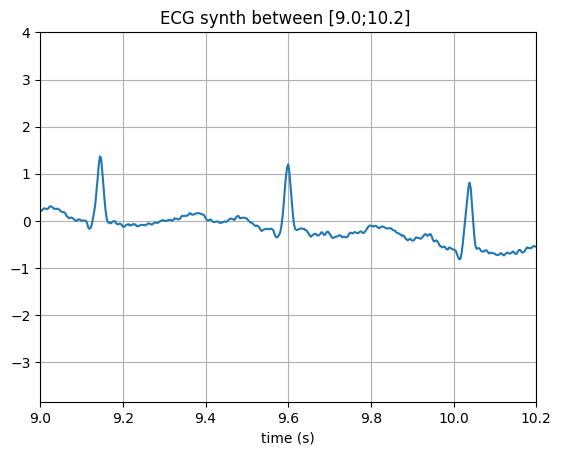

Wavelet Scalogram for ECG syn between [9.0;10.2]


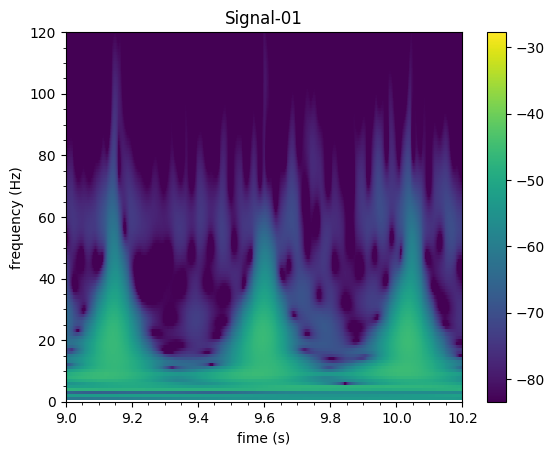

Wavelet MSSR for ECG syn between [9.0;10.2]


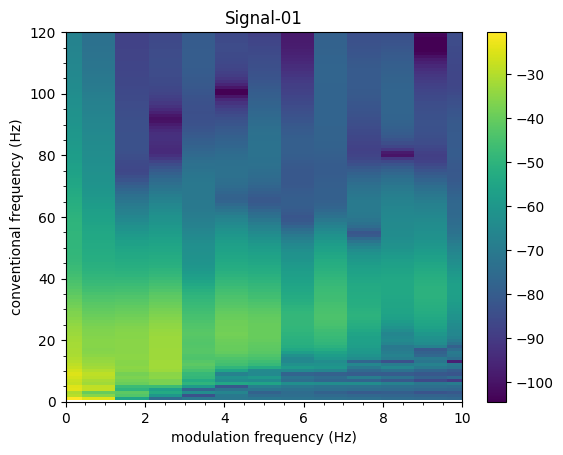

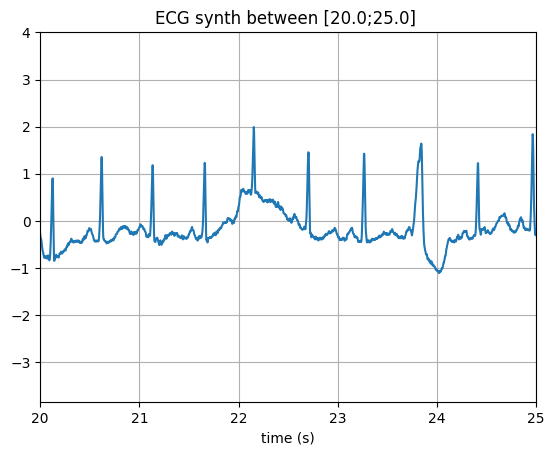

Wavelet Scalogram for ECG syn between [20.0;25.0]


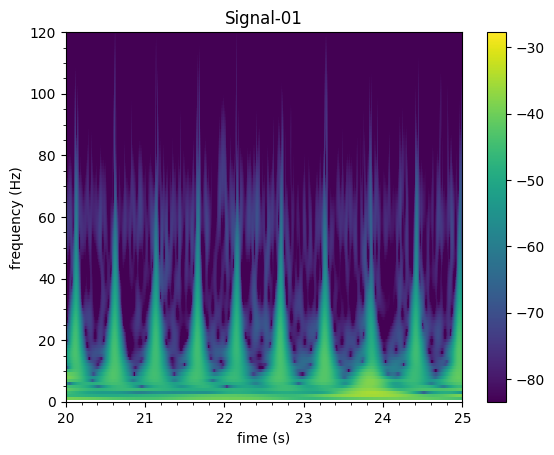

Wavelet MSSR for ECG syn between [20.0;25.0]


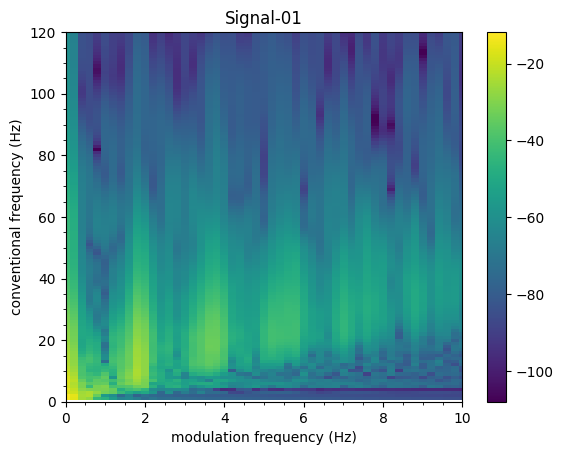

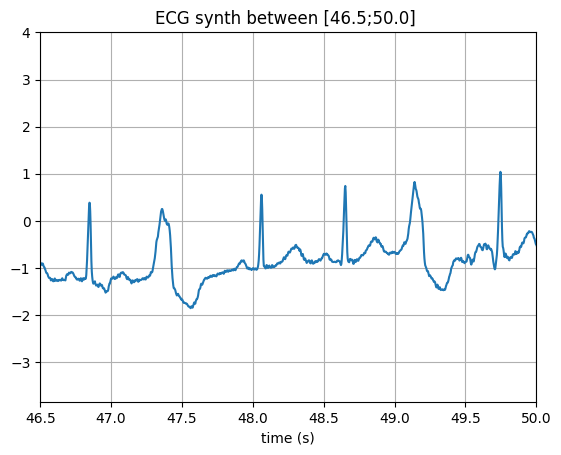

Wavelet Scalogram for ECG syn between [46.5;50.0]


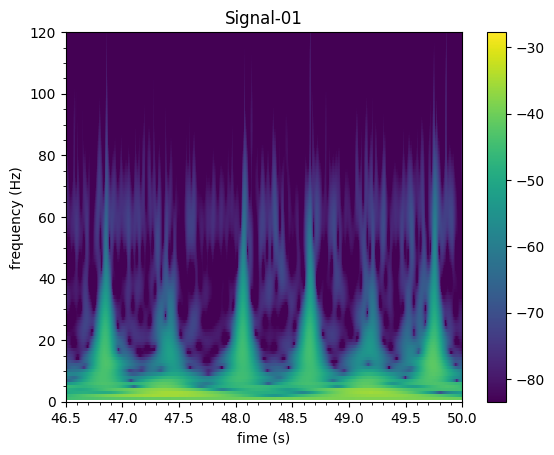

Wavelet MSSR for ECG syn between [46.5;50.0]


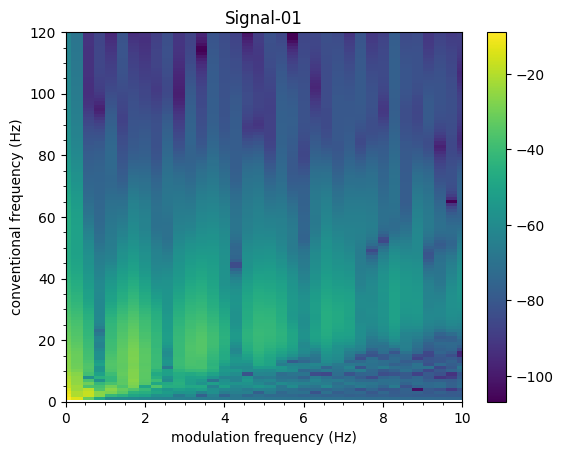

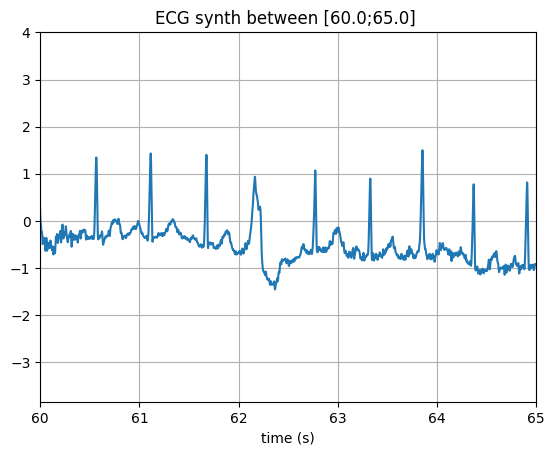

Wavelet Scalogram for ECG syn between [60.0;65.0]


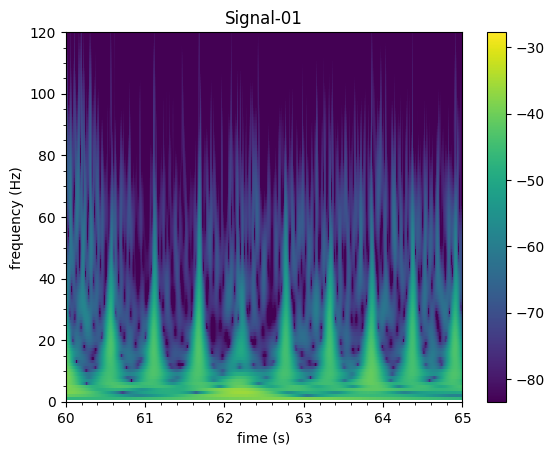

Wavelet MSSR for ECG syn between [60.0;65.0]


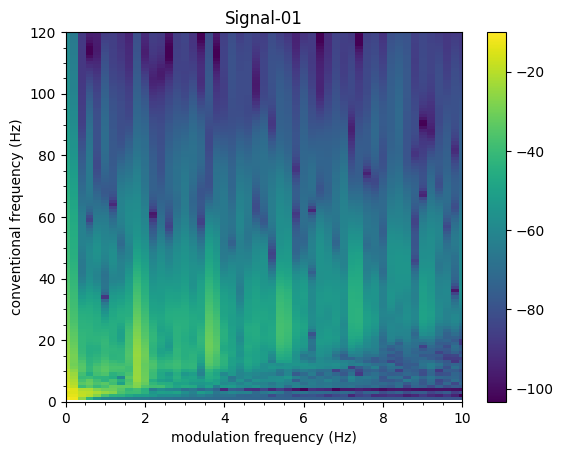

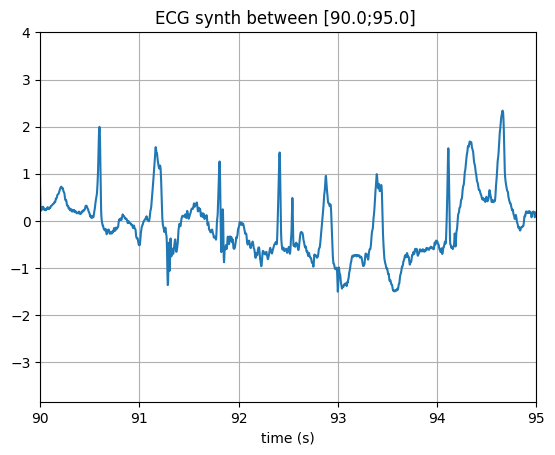

Wavelet Scalogram for ECG syn between [90.0;95.0]


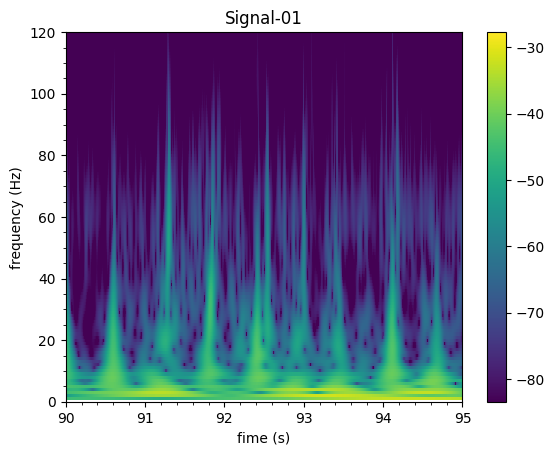

Wavelet MSSR for ECG syn between [90.0;95.0]


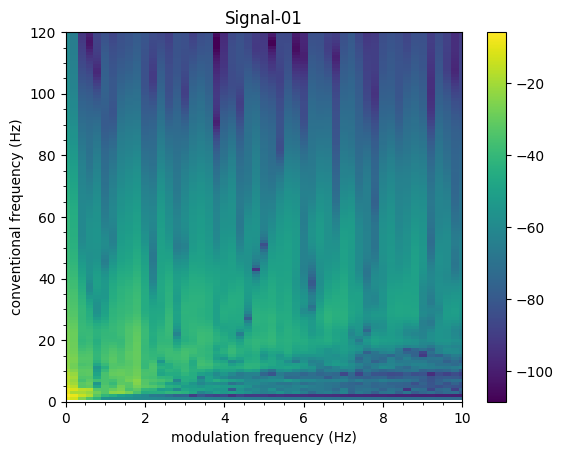

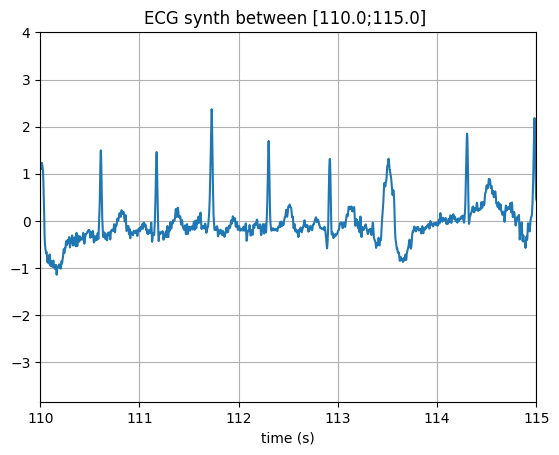

Wavelet Scalogram for ECG syn between [110.0;115.0]


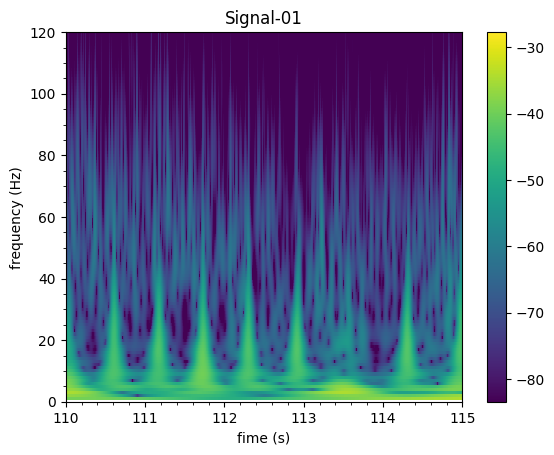

Wavelet MSSR for ECG syn between [110.0;115.0]


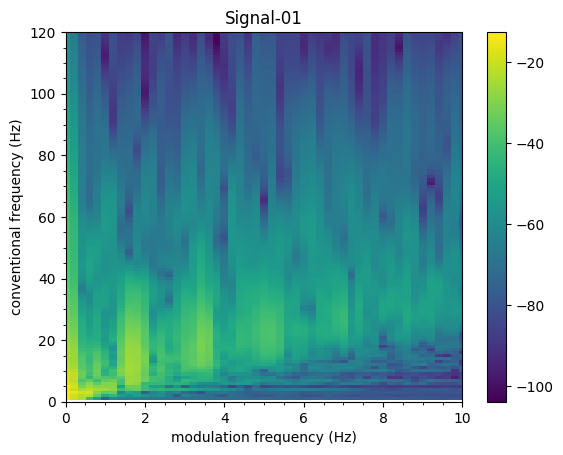

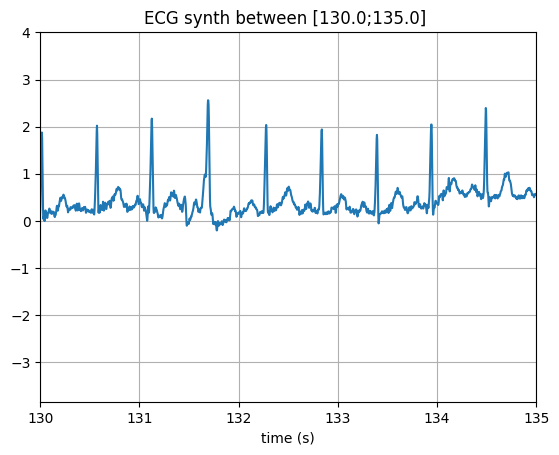

Wavelet Scalogram for ECG syn between [130.0;135.0]


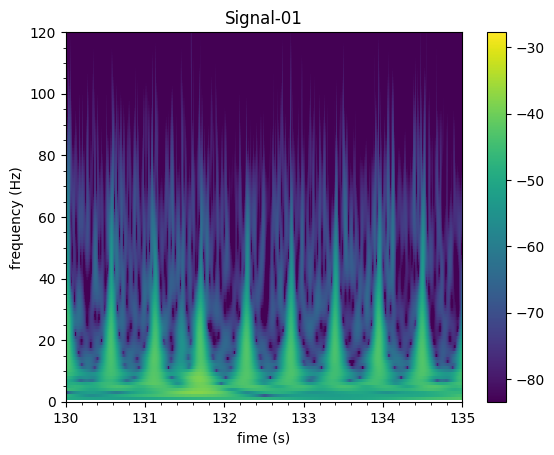

Wavelet MSSR for ECG syn between [130.0;135.0]


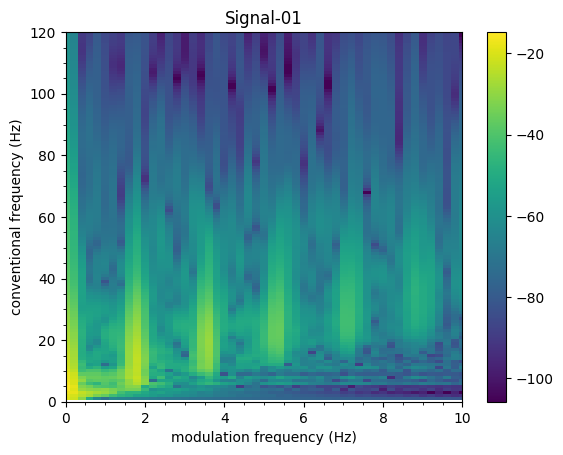

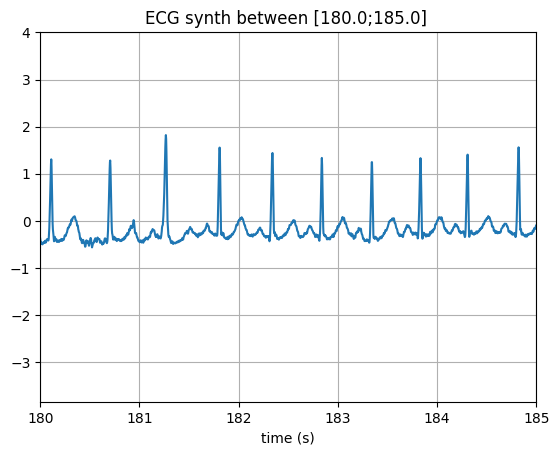

Wavelet Scalogram for ECG syn between [180.0;185.0]


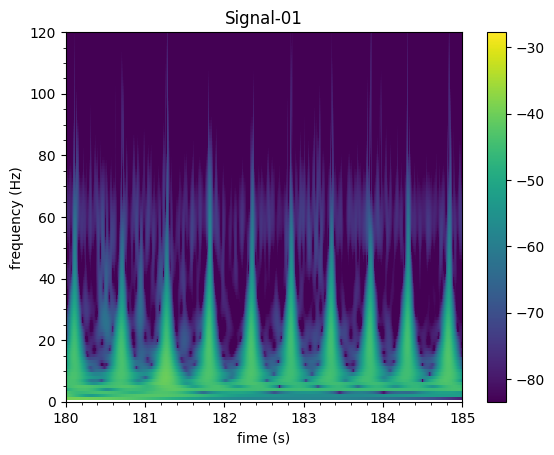

Wavelet MSSR for ECG syn between [180.0;185.0]


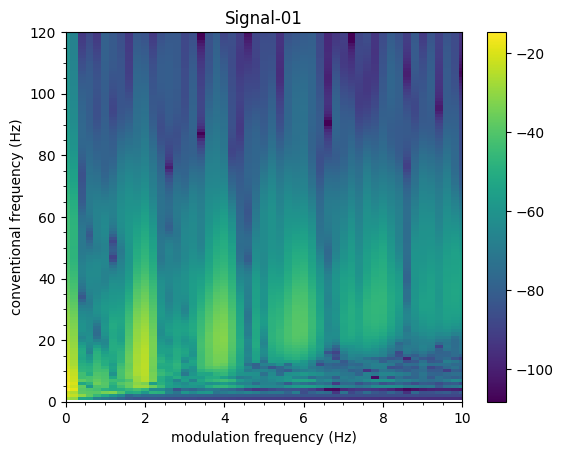

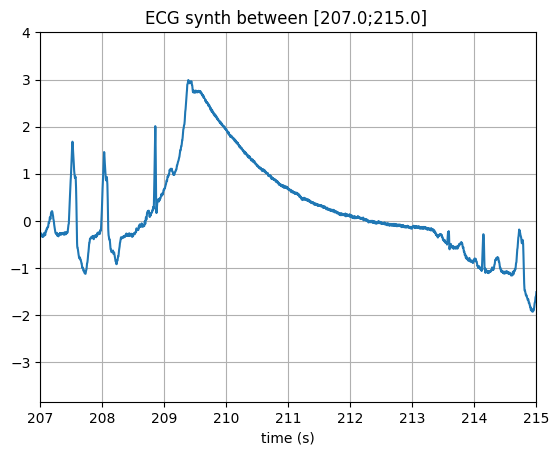

Wavelet Scalogram for ECG syn between [207.0;215.0]


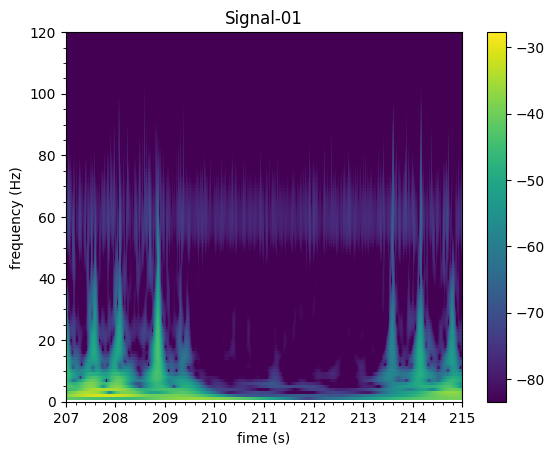

Wavelet MSSR for ECG syn between [207.0;215.0]


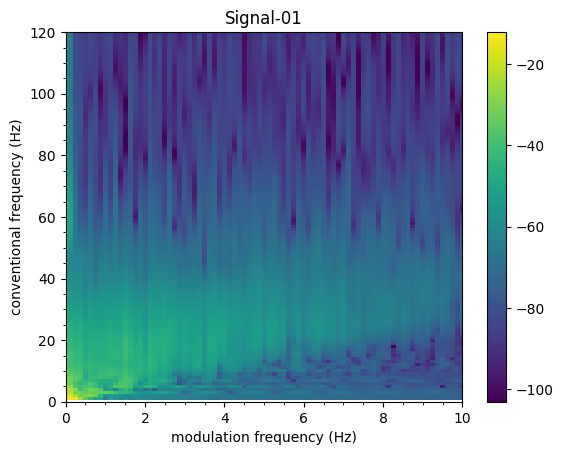

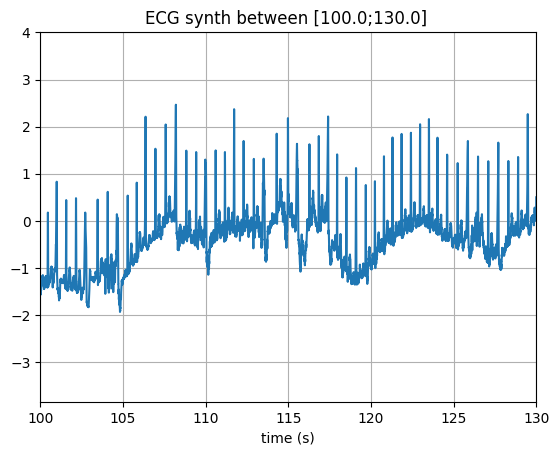

Wavelet Scalogram for ECG syn between [100.0;130.0]


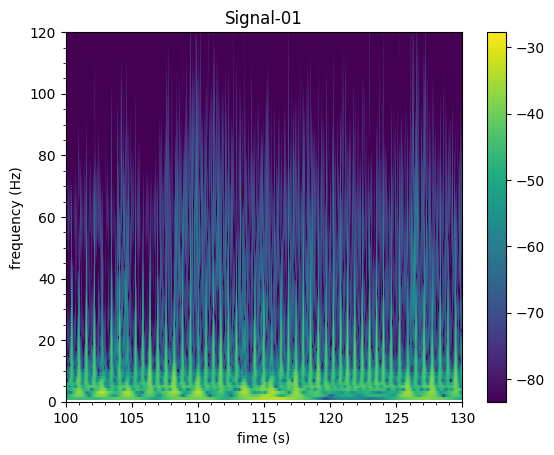

Wavelet MSSR for ECG syn between [100.0;130.0]


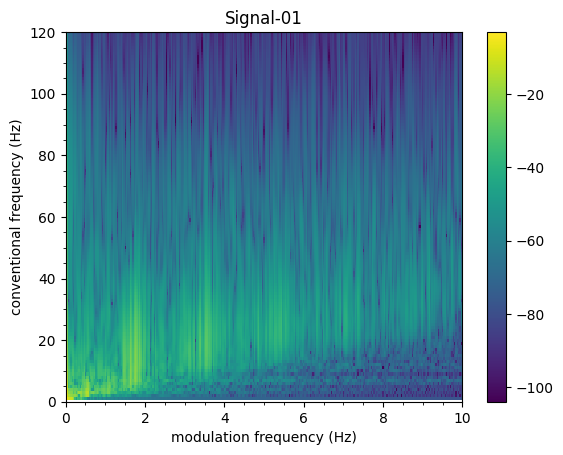

In [25]:
ecg_syn = scipy.misc.electrocardiogram()
fs = 360
time = np.arange(ecg_syn.size) / fs
interval = np.array([[9,10.2],[20,25],[46.5,50],[60,65],[90,95],[110,115],[130,135],[180,185],[207,215],[100,130]])
for inter in interval:
    MSSRw = wavelet_modulation_spectrogram(ecg_syn[np.logical_and(time>inter[0], time<inter[1])],fs)
    spectrogram_w = wavelet_spectrogram(ecg_syn,fs)
    plot_signal(ecg_syn,fs,name = f"ECG synth between [{inter[0]};{inter[1]}] ")
    plt.xlim([inter[0],inter[1]])
    plt.grid()
    plt.show()
    plt.figure()
    print(f"Wavelet Scalogram for ECG syn between [{inter[0]};{inter[1]}]")
    plot_spectrogram_data(spectrogram_w,f_range=np.array([0,120]),t_range=np.array([inter[0],inter[1]]))
    plt.show()
    print(f"Wavelet MSSR for ECG syn between [{inter[0]};{inter[1]}]")
    plot_modulation_spectrogram_data(MSSRw,modf_range=np.array([0,10]),f_range=np.array([0,120]))
    plt.show()
